# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import os 
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.misc import imsave
from scipy.misc import imresize
import numpy as np
from numpy import genfromtxt
import tensorflow as tf
from PIL import Image
import pickle
# from tensorflow_vgg import vgg16|
import collections
import time
import math

# Import GEI dataset 

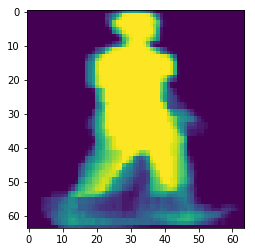

In [34]:
img = imread('{}'.format(os.path.join('OULP-C1V2_Pack/GEI/OULP-GEI-(224x224)-15f/Seq00/0000024', '0000024_55_GEI_15f.png')))
img = imresize(img, [64, 64], interp='nearest')
plt.imshow(img)
plt.show()

In [45]:
# Create Training Data
path = 'OULP-C1V2_Pack/GEI/OULP-GEI-(224x224)/Seq01'
Seq_15f_list = os.listdir(path)
Seq_15f_list.remove('.DS_Store')

Seq = []
for each_seq in Seq_15f_list:
    seq_path = os.path.join(path, each_seq)
    GEI = []
    for each_GEI in os.listdir(seq_path):
        img = imread('{}'.format(os.path.join(seq_path, each_GEI)))
        img = imresize(img, [64, 64], interp='nearest')
        GEI.append(img)
    Seq.append(np.array(GEI))
Seq = np.array(Seq)

In [46]:
with open('../gait_data/OULP_GEI/codes', 'wb') as f:
    np.save(f, Seq)

# Checkpoint 1

In [2]:
# gallery_15f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_15f_Seq00', mode='rb'))
# probe_15f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_15f_Seq01', mode='rb'))
gallery_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq00', mode='rb'))
probe_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq01', mode='rb'))

In [3]:
gallery_full = gallery_full/float(255)
probe_full = probe_full/float(255)

<br><br><br><br><br><br><br><br><br>

# Auto_Encoder 1: 55''-65''
### 先试full-full

In [4]:
# Train X
train_x = np.concatenate([gallery_full[:2573, 0], probe_full[:2573, 0]], axis=0)
train_x = np.reshape(train_x, [train_x.shape[0], train_x.shape[1], train_x.shape[2], 1])
# Train Y
train_y = np.concatenate([gallery_full[:2573, 1], probe_full[:2573, 1]], axis=0)
train_y = np.reshape(train_x, [train_x.shape[0], train_x.shape[1], train_x.shape[2], 1])
print('train_x', train_x.shape, 'train_y', train_y.shape)

# Val X
val_x = gallery_full[2573:, 0]
val_x = np.reshape(val_x, [val_x.shape[0], val_x.shape[1], val_x.shape[2], 1])
# Val Y
val_y = gallery_full[2573:, 1]
val_y = np.reshape(val_y, [val_y.shape[0], val_y.shape[1], val_y.shape[2], 1])
print('val_x', val_x.shape, 'val_y', val_y.shape)

# Test X
test_x = probe_full[2573:, 0]
test_x = np.reshape(test_x, [test_x.shape[0], test_x.shape[1], test_x.shape[2], 1])
# Test Y
test_y = probe_full[2573:, 1]
test_y = np.reshape(test_x, [test_x.shape[0], test_x.shape[1], test_x.shape[2], 1])
print('test_x', test_x.shape, 'test_y', test_y.shape)

train_x (5146, 64, 64, 1) train_y (5146, 64, 64, 1)
val_x (573, 64, 64, 1) val_y (573, 64, 64, 1)
test_x (573, 64, 64, 1) test_y (573, 64, 64, 1)


# Create Graph

In [5]:
def build_inputs_outputs():
    inputs_1 = tf.placeholder(tf.float32, (None, 64, 64, 1), name='inputs_1')
    targets_1 = tf.placeholder(tf.float32, (None, 64, 64, 1), name='targets_1')
    
    return inputs_1, targets_1

def conv_layer(inputs_, conv_name, pool_name, bn_name, relu_name, add_bacth_norm=True, is_training=True, out_dim=1, 
               kern_size=(2,2), conv_strides=(1,1), pool_size=(2,2), pool_strides=(2,2), keep_prob=0.5):
    ### Encoder
    # e.g. out_dim: 8; kern_size: (3,3); pool_size: (2,2); strides: (2,2);
    conv = tf.layers.conv2d(inputs_, out_dim, kern_size, strides=conv_strides, padding='same', activation=None,
                            name=conv_name)
    # Now 28x28x
    if add_bacth_norm:
        conv = tf.layers.batch_normalization(conv, training=is_training, name=bn_name)
        
    conv = tf.nn.relu(conv, name=relu_name)
        
    maxpool = tf.layers.max_pooling2d(conv, pool_size, pool_strides, padding='same', name=pool_name)
    
    maxpool = tf.layers.dropout(maxpool, rate=keep_prob)

    return maxpool

#     # Now 14x14x16
#     conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 14x14x8
#     maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
#     # Now 7x7x8
#     conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 7x7x8
#     encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
#     # Now 4x4x8

def deconv_layer(encoded, up_name, conv_name, bn_name, relu_name, add_batch_norm=True, is_training=True, 
                 up_size=(2,2), out_dim=1, kern_size=(2,2), conv_strides=(1,1), keep_prob=0.5):
    ### Decoder
    upsample = tf.image.resize_nearest_neighbor(encoded, up_size, name=up_name) # up_size: e.g.(7,7)
    # Now 7x7x8 kern_size: (3, 3)
    conv = tf.layers.conv2d(upsample, out_dim, kern_size, strides=conv_strides, padding='same', activation=None, 
                            name=conv_name) 
    
    if add_batch_norm:
        conv = tf.layers.batch_normalization(conv, training=is_training, name=bn_name)
    
    conv = tf.nn.relu(conv, name=relu_name)
    
    conv = tf.layers.dropout(conv, rate=keep_prob)
    
    return conv

#     # Now 7x7x8
#     upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
#     # Now 14x14x8
#     conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 14x14x8
#     upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
#     # Now 28x28x8
#     conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 28x28x16

def output_layer(conv, logits_name, bn_name, decoded_name, add_batch_norm=True, is_training=True, 
                 out_dim=1, kern_size=(3,3), conv_strides=(1,1)):
    logits = tf.layers.conv2d(conv, out_dim, kern_size, strides=conv_strides, padding='same', activation=None, 
                              name=logits_name)
    
    if add_batch_norm:
        conv = tf.layers.batch_normalization(conv, training=is_training, name=bn_name)
    #Now 28x28x1
    decoded = tf.nn.sigmoid(logits, name=decoded_name)
    
    return logits, decoded

In [6]:
def build_graph(kern_size, conv_strides, pool_size, pool_strides, de_kern_size, 
                de_conv_strides, out_kern_size, out_strides, up_size=[(16,16), (32,32), (64,64)], is_training=True):
    
    # reset graph
    tf.reset_default_graph()
    
    with tf.name_scope('inputs_targets'):
        inputs_1, targets_1 = build_inputs_outputs()
    
    keep_p = tf.placeholder(tf.float32, name="keep_prob")
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    with tf.name_scope('conv_layers'):
        
        maxpool_1 = conv_layer(inputs_1, 'conv_1', 'pool_1', 'bn_1', 'relu_1', add_bacth_norm=False, 
                               is_training=is_training, out_dim=16, kern_size=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
        maxpool_2 = conv_layer(maxpool_1, 'conv_2', 'pool_2', 'bn_2', 'relu_2', add_bacth_norm=True, 
                               is_training=is_training, out_dim=8, kern_size=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
        maxpool_3 = conv_layer(maxpool_2, 'conv_3', 'pool_3', 'bn_3', 'relu_3', add_bacth_norm=True, 
                               is_training=is_training, out_dim=8, kern_size=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
    with tf.name_scope('deconv_layers'):
        
        deconv_1 = deconv_layer(maxpool_3, 'up_1', 'deconv_1', 'de_bn_1', 'de_relu_1', add_batch_norm=True, 
                              is_training=is_training, up_size=up_size[0], out_dim=8, kern_size=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
        deconv_2 = deconv_layer(deconv_1, 'up_2', 'deconv_2', 'de_bn_2', 'de_relu_2', add_batch_norm=True, 
                              is_training=is_training, up_size=up_size[1], out_dim=8, kern_size=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
        deconv_3 = deconv_layer(deconv_2, 'up_3', 'deconv_3', 'de_bn_3', 'de_relu_3', add_batch_norm=True, 
                              is_training=is_training, up_size=up_size[2], out_dim=16, kern_size=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
    with tf.name_scope('output_layer'):
        
        logits, decoded = output_layer(deconv_3, 'logits', 'bn', 'decoded', add_batch_norm=True, is_training=is_training, 
                                       out_dim=1, kern_size=out_kern_size, conv_strides=out_strides)
        
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_1, logits=logits, name='loss')
    cost = tf.reduce_mean(loss, name='cost')
    opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.name_scope('saver'):
        saver = tf.train.Saver()
        
#     merged = tf.summary.merge_all()
    
    export_nodes = ['inputs_1', 'targets_1', 'maxpool_1', 'maxpool_2', 'maxpool_3', 'deconv_1', 'deconv_2', 
                    'deconv_3', 'logits', 'decoded', 'loss', 'cost', 'opt', 'saver', 'learning_rate', 'keep_p']
    
    Graph = collections.namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

In [10]:
def get_batches(data, target, batch_size):
    n_batches = len(data)//batch_size
    data = data[:batch_size * n_batches]
    target = target[:batch_size * n_batches]
    for ii in range(0, batch_size*n_batches, batch_size):
        data_batch = data[ii:ii + batch_size]
        target_batch = target[ii:ii + batch_size]
        
        yield data_batch, target_batch
        
        
def cal_accuracy(decoded, target):
    error = abs(decoded - target)
    Acc = (np.sum(error <= 0.1)/(decoded.shape[0]*decoded.shape[1]*decoded.shape[2]*decoded.shape[3]))*100
    
    return Acc

In [8]:
error = np.random.rand(10,5,5,1)
np.sum(error >= 0.9)/100

0.25

In [37]:
def train(model, epochs, save_string):

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())
        
        iteration = 1
        mean_val_loss = 0
        mean_val_acc = 0
        count_loss_not_decrease_epochs = 0
        count_acc_not_increase_epochs = 0
        Last_val_loss = 0
        Last_val_acc = 0
        
        
        for e in range(epochs):
            for train_batch, target_batch in get_batches(train_x, train_y, batch_size):
                    
                start = time.time()
                
                feed_1 = {
                        model.inputs_1: train_batch, 
                        model.targets_1: target_batch,
                        model.keep_p: 0.7,
                        model.learning_rate: lr
                        }

                train_loss, _, decoded_img = sess.run([model.cost, model.opt, model.decoded], feed_dict=feed_1)
                
                train_acc = cal_accuracy(decoded_img, target_batch)
                
                if iteration%25==0:
                    end = time.time()
#                     acc = calculate_accuracy(sess, pred, target_batch, sq_length)
                    print(
                          "Epoch: {}/{},".format(e+1, epochs),' ',
                          "Iteration: {},".format(iteration),' ',
                          "Train loss: {:.3f},".format(train_loss),' '
                          "{:.1f}s /batch.".format((end-start)/5),' '
                          "Train Accuracy: %{:.3f}".format(train_acc) 
                    )
                                
                ##############################################################
                ######################## VALIDATION ##########################
                ##############################################################
                
                if iteration%75==0:
#                     training = True
                    validation_loss = []
                    validation_acc = []
                    
                    if batch_size >= len(val_x):
                        val_batch_size = len(val_x)
                    else: 
                        val_batch_size = batch_size
                        
                    for ii, (val_batch, val_target_batch) in enumerate(get_batches(val_x, val_y, val_batch_size)):
#                         print(ii, len(val_x)//val_batch_size)
                        feed_2 = {
                                model.inputs_1: val_batch,
                                model.targets_1: val_target_batch,
                                model.keep_p: 1
                                }
                        
                        val_loss, val_decoded_img, max_pool_3 = sess.run([model.cost, model.decoded, model.maxpool_3], 
                                                                          feed_dict=feed_2)

                        val_acc = cal_accuracy(val_decoded_img, val_target_batch)
                        
                        validation_loss.append(val_loss)
                        validation_acc.append(val_acc)
                        
                        
                        # plot out
#                         if ii == (len(val_x)//val_batch_size) - 1:
#                         fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
#                         in_imgs = val_target_batch[:10]
#                         reconstructed = val_decoded_img[:10]

#                         for images, row in zip([in_imgs, reconstructed], axes):
#                             for img, ax in zip(images, row):
#                                 ax.imshow(img.reshape((64, 64)), cmap='Greys_r')
#                                 plt.show()
#                                 ax.get_xaxis().set_visible(True)
#                                 ax.get_yaxis().set_visible(True)

#                         fig.tight_layout(pad=0.1)
                            
                    Last_val_loss = mean_val_loss
                    Last_val_acc = mean_val_acc
                    mean_val_loss = np.mean(np.array(validation_loss))
                    mean_val_acc = np.mean(np.array(validation_acc))
                    
                    print()
                    print("Validation loss: {:.3f},".format(mean_val_loss))
                    print()
                    
                    print("Validation accuracy: {:.3f},".format(mean_val_acc),' '
                          "maxpool_3.shape: {}.".format(max_pool_3[0].shape),' '
                          "batch_size/lr: {}/{}".format(batch_size, lr))
                    print()
                    
                iteration += 1
                
#             # Early stopping  
#             if mean_val_acc - Last_val_acc <= -0.5:
#                 count_acc_not_increase_epochs += 1
#             if Last_val_loss - mean_val_loss <= -0.04:
#                 count_loss_not_decrease_epochs += 1
                
#             if mean_val_acc - Last_val_acc <= -2:
#                 break
#             if count_acc_not_increase_epochs >= 20:
#                 break
#             if count_loss_not_decrease_epochs >= 20:
#                 break
                
        model.saver.save(sess, r"{}".format(save_string))

In [40]:
!mkdir checkpoints_view_invariant

training = True
num_layers = 3
epochs = 3000
batch_size = 80
conv_kern_size = (3,3)
conv_strides = (1,1)
pool_size = (2,2)
pool_strides = (2,2)
up_size = [(16,16), (32,32), (64,64)]
de_kern_size = (3,3)
de_conv_strides = (1,1)
out_kern_size = (3,3)
out_strides = (1,1)

for batch_size in [50]:
    for lr in [0.001]:
    #                 log_string = 'logs/4/lr={},nl={},ls={},bs={}'.format(lr, num_layers, lstm_size, batch_size)
        save_string = './checkpoints_view_invariant/lr={}_nl={}_bs={}.ckpt'.format(lr, num_layers, batch_size)

    #             writer = tf.summary.FileWriter(log_string)

        model = build_graph(conv_kern_size, conv_strides, pool_size, pool_strides, de_kern_size, de_conv_strides,
                            out_kern_size, out_strides, up_size=up_size, is_training=training)

        train(model, epochs, save_string)

        print(' ')
        print(' ')
        print("leraning_rate={},num_layers={},batch_size={} finished, saved".format(lr, num_layers, batch_size))
        print(' ')
        print(' ')

mkdir: cannot create directory ‘checkpoints_view_invariant’: File exists
Epoch: 1/3000,   Iteration: 25,   Train loss: 0.310,  0.0s /batch.  Train Accuracy: %62.446
Epoch: 1/3000,   Iteration: 50,   Train loss: 0.268,  0.0s /batch.  Train Accuracy: %77.110
Epoch: 1/3000,   Iteration: 75,   Train loss: 0.261,  0.0s /batch.  Train Accuracy: %82.216

Validation loss: 0.260,

Validation accuracy: 76.179,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1/3000,   Iteration: 100,   Train loss: 0.244,  0.0s /batch.  Train Accuracy: %85.116
Epoch: 2/3000,   Iteration: 125,   Train loss: 0.255,  0.0s /batch.  Train Accuracy: %87.170
Epoch: 2/3000,   Iteration: 150,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %88.109

Validation loss: 0.246,

Validation accuracy: 81.798,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2/3000,   Iteration: 175,   Train loss: 0.242,  0.0s /batch.  Train Accuracy: %89.421
Epoch: 2/3000,   Iteration: 200,   Train loss: 0.239,  0.0s

Epoch: 16/3000,   Iteration: 1600,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %95.571
Epoch: 16/3000,   Iteration: 1625,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %95.182
Epoch: 17/3000,   Iteration: 1650,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %95.683

Validation loss: 0.235,

Validation accuracy: 85.573,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 17/3000,   Iteration: 1675,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %94.688
Epoch: 17/3000,   Iteration: 1700,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %95.598
Epoch: 17/3000,   Iteration: 1725,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %95.425

Validation loss: 0.238,

Validation accuracy: 84.998,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 18/3000,   Iteration: 1750,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %95.515
Epoch: 18/3000,   Iteration: 1775,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %95.578
Epoch: 18/3000,   It

Epoch: 32/3000,   Iteration: 3175,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %96.532
Epoch: 32/3000,   Iteration: 3200,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %95.944
Epoch: 32/3000,   Iteration: 3225,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %96.540

Validation loss: 0.238,

Validation accuracy: 84.911,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 32/3000,   Iteration: 3250,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %96.443
Epoch: 33/3000,   Iteration: 3275,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %96.397
Epoch: 33/3000,   Iteration: 3300,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %96.119

Validation loss: 0.234,

Validation accuracy: 86.011,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 33/3000,   Iteration: 3325,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %96.111
Epoch: 33/3000,   Iteration: 3350,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %95.954
Epoch: 34/3000,   It

Epoch: 47/3000,   Iteration: 4750,   Train loss: 0.236,  0.0s /batch.  Train Accuracy: %96.955
Epoch: 47/3000,   Iteration: 4775,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %96.299
Epoch: 48/3000,   Iteration: 4800,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %96.984

Validation loss: 0.235,

Validation accuracy: 85.782,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 48/3000,   Iteration: 4825,   Train loss: 0.213,  0.0s /batch.  Train Accuracy: %95.813
Epoch: 48/3000,   Iteration: 4850,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %96.711
Epoch: 48/3000,   Iteration: 4875,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %96.587

Validation loss: 0.236,

Validation accuracy: 86.410,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 49/3000,   Iteration: 4900,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %96.989
Epoch: 49/3000,   Iteration: 4925,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %96.574
Epoch: 49/3000,   It

Epoch: 63/3000,   Iteration: 6325,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %96.918
Epoch: 63/3000,   Iteration: 6350,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %96.051
Epoch: 63/3000,   Iteration: 6375,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %97.004

Validation loss: 0.237,

Validation accuracy: 86.292,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 63/3000,   Iteration: 6400,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %95.168
Epoch: 63/3000,   Iteration: 6425,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %96.996
Epoch: 64/3000,   Iteration: 6450,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %94.890

Validation loss: 0.249,

Validation accuracy: 81.996,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 64/3000,   Iteration: 6475,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %97.113
Epoch: 64/3000,   Iteration: 6500,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %97.568
Epoch: 64/3000,   It

Epoch: 78/3000,   Iteration: 7900,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %97.344
Epoch: 78/3000,   Iteration: 7925,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %96.909
Epoch: 78/3000,   Iteration: 7950,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.280

Validation loss: 0.238,

Validation accuracy: 86.008,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 79/3000,   Iteration: 7975,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %96.835
Epoch: 79/3000,   Iteration: 8000,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %97.510
Epoch: 79/3000,   Iteration: 8025,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %97.394

Validation loss: 0.237,

Validation accuracy: 85.614,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 79/3000,   Iteration: 8050,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %97.124
Epoch: 80/3000,   Iteration: 8075,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %97.565
Epoch: 80/3000,   It

Epoch: 93/3000,   Iteration: 9475,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.533
Epoch: 94/3000,   Iteration: 9500,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %97.578
Epoch: 94/3000,   Iteration: 9525,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %97.540

Validation loss: 0.237,

Validation accuracy: 85.967,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 94/3000,   Iteration: 9550,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %97.743
Epoch: 94/3000,   Iteration: 9575,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %97.715
Epoch: 95/3000,   Iteration: 9600,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %97.686

Validation loss: 0.236,

Validation accuracy: 86.110,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 95/3000,   Iteration: 9625,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.638
Epoch: 95/3000,   Iteration: 9650,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %97.549
Epoch: 95/3000,   It

Epoch: 109/3000,   Iteration: 11050,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %97.246
Epoch: 109/3000,   Iteration: 11075,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %97.473
Epoch: 109/3000,   Iteration: 11100,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %97.729

Validation loss: 0.235,

Validation accuracy: 86.674,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 110/3000,   Iteration: 11125,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %97.619
Epoch: 110/3000,   Iteration: 11150,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %97.504
Epoch: 110/3000,   Iteration: 11175,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %97.837

Validation loss: 0.238,

Validation accuracy: 85.278,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 110/3000,   Iteration: 11200,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.619
Epoch: 111/3000,   Iteration: 11225,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %97.835
Epoc

Epoch: 124/3000,   Iteration: 12600,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %97.523

Validation loss: 0.236,

Validation accuracy: 86.549,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 124/3000,   Iteration: 12625,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %97.846
Epoch: 125/3000,   Iteration: 12650,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %97.222
Epoch: 125/3000,   Iteration: 12675,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.293

Validation loss: 0.240,

Validation accuracy: 85.493,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 125/3000,   Iteration: 12700,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %97.750
Epoch: 125/3000,   Iteration: 12725,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %96.810
Epoch: 125/3000,   Iteration: 12750,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %97.549

Validation loss: 0.235,

Validation accuracy: 86.506,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 139/3000,   Iteration: 14125,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %97.722
Epoch: 139/3000,   Iteration: 14150,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.141
Epoch: 139/3000,   Iteration: 14175,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %97.844

Validation loss: 0.237,

Validation accuracy: 86.401,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 140/3000,   Iteration: 14200,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %97.803
Epoch: 140/3000,   Iteration: 14225,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %97.744
Epoch: 140/3000,   Iteration: 14250,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %97.938

Validation loss: 0.241,

Validation accuracy: 85.206,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 140/3000,   Iteration: 14275,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %97.875
Epoch: 141/3000,   Iteration: 14300,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.804
Epoc

Epoch: 154/3000,   Iteration: 15675,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %97.930

Validation loss: 0.238,

Validation accuracy: 85.864,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 154/3000,   Iteration: 15700,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %97.637
Epoch: 155/3000,   Iteration: 15725,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.003
Epoch: 155/3000,   Iteration: 15750,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %97.745

Validation loss: 0.239,

Validation accuracy: 85.972,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 155/3000,   Iteration: 15775,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.203
Epoch: 155/3000,   Iteration: 15800,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %97.946
Epoch: 156/3000,   Iteration: 15825,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.004

Validation loss: 0.235,

Validation accuracy: 86.486,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 169/3000,   Iteration: 17200,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.170
Epoch: 169/3000,   Iteration: 17225,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.086
Epoch: 170/3000,   Iteration: 17250,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.043

Validation loss: 0.236,

Validation accuracy: 86.368,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 170/3000,   Iteration: 17275,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.977
Epoch: 170/3000,   Iteration: 17300,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %97.962
Epoch: 170/3000,   Iteration: 17325,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %97.588

Validation loss: 0.234,

Validation accuracy: 86.685,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 171/3000,   Iteration: 17350,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %97.761
Epoch: 171/3000,   Iteration: 17375,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %97.636
Epoc

Epoch: 184/3000,   Iteration: 18750,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.069

Validation loss: 0.234,

Validation accuracy: 86.848,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 185/3000,   Iteration: 18775,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %97.878
Epoch: 185/3000,   Iteration: 18800,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %97.888
Epoch: 185/3000,   Iteration: 18825,   Train loss: 0.236,  0.0s /batch.  Train Accuracy: %98.265

Validation loss: 0.237,

Validation accuracy: 85.579,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 185/3000,   Iteration: 18850,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %97.893
Epoch: 186/3000,   Iteration: 18875,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.138
Epoch: 186/3000,   Iteration: 18900,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.897

Validation loss: 0.237,

Validation accuracy: 86.842,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 199/3000,   Iteration: 20275,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.012
Epoch: 200/3000,   Iteration: 20300,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %97.587
Epoch: 200/3000,   Iteration: 20325,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %97.432

Validation loss: 0.241,

Validation accuracy: 85.695,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 200/3000,   Iteration: 20350,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %97.990
Epoch: 200/3000,   Iteration: 20375,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %97.207
Epoch: 200/3000,   Iteration: 20400,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %97.816

Validation loss: 0.236,

Validation accuracy: 86.559,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 201/3000,   Iteration: 20425,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %96.843
Epoch: 201/3000,   Iteration: 20450,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %97.838
Epoc

Epoch: 214/3000,   Iteration: 21825,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.048

Validation loss: 0.238,

Validation accuracy: 86.440,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 215/3000,   Iteration: 21850,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %97.904
Epoch: 215/3000,   Iteration: 21875,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %97.917
Epoch: 215/3000,   Iteration: 21900,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.039

Validation loss: 0.240,

Validation accuracy: 85.448,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 215/3000,   Iteration: 21925,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.051
Epoch: 216/3000,   Iteration: 21950,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.946
Epoch: 216/3000,   Iteration: 21975,   Train loss: 0.213,  0.0s /batch.  Train Accuracy: %98.053

Validation loss: 0.240,

Validation accuracy: 86.140,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 229/3000,   Iteration: 23350,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %97.804
Epoch: 230/3000,   Iteration: 23375,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.178
Epoch: 230/3000,   Iteration: 23400,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %97.976

Validation loss: 0.238,

Validation accuracy: 86.144,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 230/3000,   Iteration: 23425,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.352
Epoch: 230/3000,   Iteration: 23450,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.143
Epoch: 231/3000,   Iteration: 23475,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.258

Validation loss: 0.235,

Validation accuracy: 86.520,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 231/3000,   Iteration: 23500,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %97.877
Epoch: 231/3000,   Iteration: 23525,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %97.967
Epoc

Epoch: 245/3000,   Iteration: 24900,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.196

Validation loss: 0.236,

Validation accuracy: 86.390,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 245/3000,   Iteration: 24925,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.118
Epoch: 245/3000,   Iteration: 24950,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.138
Epoch: 245/3000,   Iteration: 24975,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %97.782

Validation loss: 0.234,

Validation accuracy: 86.764,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 246/3000,   Iteration: 25000,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.013
Epoch: 246/3000,   Iteration: 25025,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %97.896
Epoch: 246/3000,   Iteration: 25050,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.101

Validation loss: 0.238,

Validation accuracy: 85.282,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 260/3000,   Iteration: 26425,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.012
Epoch: 260/3000,   Iteration: 26450,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.047
Epoch: 260/3000,   Iteration: 26475,   Train loss: 0.236,  0.0s /batch.  Train Accuracy: %98.329

Validation loss: 0.237,

Validation accuracy: 85.627,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 260/3000,   Iteration: 26500,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.014
Epoch: 261/3000,   Iteration: 26525,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.247
Epoch: 261/3000,   Iteration: 26550,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.087

Validation loss: 0.237,

Validation accuracy: 86.805,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 261/3000,   Iteration: 26575,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.095
Epoch: 261/3000,   Iteration: 26600,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.198
Epoc

Epoch: 275/3000,   Iteration: 27975,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %97.449

Validation loss: 0.241,

Validation accuracy: 85.687,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 275/3000,   Iteration: 28000,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.058
Epoch: 275/3000,   Iteration: 28025,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %97.491
Epoch: 275/3000,   Iteration: 28050,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %97.933

Validation loss: 0.237,

Validation accuracy: 86.541,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 276/3000,   Iteration: 28075,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %97.141
Epoch: 276/3000,   Iteration: 28100,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.947
Epoch: 276/3000,   Iteration: 28125,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.031

Validation loss: 0.244,

Validation accuracy: 84.331,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 290/3000,   Iteration: 29500,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.056
Epoch: 290/3000,   Iteration: 29525,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.029
Epoch: 290/3000,   Iteration: 29550,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.165

Validation loss: 0.240,

Validation accuracy: 85.514,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 290/3000,   Iteration: 29575,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.170
Epoch: 291/3000,   Iteration: 29600,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.121
Epoch: 291/3000,   Iteration: 29625,   Train loss: 0.213,  0.0s /batch.  Train Accuracy: %98.135

Validation loss: 0.240,

Validation accuracy: 86.152,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 291/3000,   Iteration: 29650,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.401
Epoch: 291/3000,   Iteration: 29675,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.153
Epoc

Epoch: 305/3000,   Iteration: 31050,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.127

Validation loss: 0.239,

Validation accuracy: 86.193,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 305/3000,   Iteration: 31075,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.380
Epoch: 305/3000,   Iteration: 31100,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.256
Epoch: 306/3000,   Iteration: 31125,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.390

Validation loss: 0.235,

Validation accuracy: 86.527,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 306/3000,   Iteration: 31150,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %97.999
Epoch: 306/3000,   Iteration: 31175,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.042
Epoch: 306/3000,   Iteration: 31200,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %97.858

Validation loss: 0.236,

Validation accuracy: 86.548,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 320/3000,   Iteration: 32575,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.224
Epoch: 320/3000,   Iteration: 32600,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.216
Epoch: 320/3000,   Iteration: 32625,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %97.906

Validation loss: 0.235,

Validation accuracy: 86.854,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 321/3000,   Iteration: 32650,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.109
Epoch: 321/3000,   Iteration: 32675,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %97.965
Epoch: 321/3000,   Iteration: 32700,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.178

Validation loss: 0.239,

Validation accuracy: 85.168,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 321/3000,   Iteration: 32725,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.169
Epoch: 322/3000,   Iteration: 32750,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.192
Epoc

Epoch: 335/3000,   Iteration: 34125,   Train loss: 0.236,  0.0s /batch.  Train Accuracy: %98.425

Validation loss: 0.238,

Validation accuracy: 85.715,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 335/3000,   Iteration: 34150,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.156
Epoch: 336/3000,   Iteration: 34175,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.316
Epoch: 336/3000,   Iteration: 34200,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.123

Validation loss: 0.237,

Validation accuracy: 86.701,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 336/3000,   Iteration: 34225,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.168
Epoch: 336/3000,   Iteration: 34250,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.243
Epoch: 337/3000,   Iteration: 34275,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.042

Validation loss: 0.236,

Validation accuracy: 86.723,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 350/3000,   Iteration: 35650,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.149
Epoch: 350/3000,   Iteration: 35675,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %97.650
Epoch: 350/3000,   Iteration: 35700,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.043

Validation loss: 0.237,

Validation accuracy: 86.594,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 351/3000,   Iteration: 35725,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %97.254
Epoch: 351/3000,   Iteration: 35750,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.018
Epoch: 351/3000,   Iteration: 35775,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %97.982

Validation loss: 0.244,

Validation accuracy: 84.328,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 351/3000,   Iteration: 35800,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.355
Epoch: 352/3000,   Iteration: 35825,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.407
Epoc

Epoch: 365/3000,   Iteration: 37200,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.250

Validation loss: 0.240,

Validation accuracy: 85.552,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 365/3000,   Iteration: 37225,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.254
Epoch: 366/3000,   Iteration: 37250,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.163
Epoch: 366/3000,   Iteration: 37275,   Train loss: 0.213,  0.0s /batch.  Train Accuracy: %98.248

Validation loss: 0.240,

Validation accuracy: 86.192,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 366/3000,   Iteration: 37300,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.468
Epoch: 366/3000,   Iteration: 37325,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.180
Epoch: 367/3000,   Iteration: 37350,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.344

Validation loss: 0.236,

Validation accuracy: 86.525,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 380/3000,   Iteration: 38725,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.431
Epoch: 380/3000,   Iteration: 38750,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.357
Epoch: 381/3000,   Iteration: 38775,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.395

Validation loss: 0.236,

Validation accuracy: 86.528,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 381/3000,   Iteration: 38800,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.070
Epoch: 381/3000,   Iteration: 38825,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.133
Epoch: 381/3000,   Iteration: 38850,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %97.913

Validation loss: 0.236,

Validation accuracy: 86.641,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 382/3000,   Iteration: 38875,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.391
Epoch: 382/3000,   Iteration: 38900,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.063
Epoc

Epoch: 395/3000,   Iteration: 40275,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.002

Validation loss: 0.235,

Validation accuracy: 86.875,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 396/3000,   Iteration: 40300,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.177
Epoch: 396/3000,   Iteration: 40325,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.096
Epoch: 396/3000,   Iteration: 40350,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.254

Validation loss: 0.239,

Validation accuracy: 85.244,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 396/3000,   Iteration: 40375,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.277
Epoch: 397/3000,   Iteration: 40400,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.245
Epoch: 397/3000,   Iteration: 40425,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.215

Validation loss: 0.236,

Validation accuracy: 86.831,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 410/3000,   Iteration: 41800,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.186
Epoch: 411/3000,   Iteration: 41825,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.368
Epoch: 411/3000,   Iteration: 41850,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.131

Validation loss: 0.237,

Validation accuracy: 86.787,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 411/3000,   Iteration: 41875,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.206
Epoch: 411/3000,   Iteration: 41900,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.314
Epoch: 412/3000,   Iteration: 41925,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.094

Validation loss: 0.236,

Validation accuracy: 86.730,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 412/3000,   Iteration: 41950,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.129
Epoch: 412/3000,   Iteration: 41975,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.032
Epoc

Epoch: 425/3000,   Iteration: 43350,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.123

Validation loss: 0.237,

Validation accuracy: 86.604,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 426/3000,   Iteration: 43375,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %97.460
Epoch: 426/3000,   Iteration: 43400,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.068
Epoch: 426/3000,   Iteration: 43425,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.061

Validation loss: 0.244,

Validation accuracy: 84.368,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 426/3000,   Iteration: 43450,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.388
Epoch: 427/3000,   Iteration: 43475,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.431
Epoch: 427/3000,   Iteration: 43500,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.313

Validation loss: 0.238,

Validation accuracy: 86.560,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 440/3000,   Iteration: 44875,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.310
Epoch: 441/3000,   Iteration: 44900,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.226
Epoch: 441/3000,   Iteration: 44925,   Train loss: 0.213,  0.0s /batch.  Train Accuracy: %98.328

Validation loss: 0.240,

Validation accuracy: 86.243,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 441/3000,   Iteration: 44950,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.511
Epoch: 441/3000,   Iteration: 44975,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.270
Epoch: 442/3000,   Iteration: 45000,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.374

Validation loss: 0.236,

Validation accuracy: 86.523,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 442/3000,   Iteration: 45025,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %97.979
Epoch: 442/3000,   Iteration: 45050,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.411
Epoc

Epoch: 456/3000,   Iteration: 46425,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.451

Validation loss: 0.236,

Validation accuracy: 86.559,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 456/3000,   Iteration: 46450,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.102
Epoch: 456/3000,   Iteration: 46475,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.180
Epoch: 456/3000,   Iteration: 46500,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %97.993

Validation loss: 0.236,

Validation accuracy: 86.628,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 457/3000,   Iteration: 46525,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.423
Epoch: 457/3000,   Iteration: 46550,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.103
Epoch: 457/3000,   Iteration: 46575,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.445

Validation loss: 0.239,

Validation accuracy: 85.685,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 471/3000,   Iteration: 47950,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.239
Epoch: 471/3000,   Iteration: 47975,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.188
Epoch: 471/3000,   Iteration: 48000,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.309

Validation loss: 0.239,

Validation accuracy: 85.315,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 471/3000,   Iteration: 48025,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.307
Epoch: 472/3000,   Iteration: 48050,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.307
Epoch: 472/3000,   Iteration: 48075,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.279

Validation loss: 0.237,

Validation accuracy: 86.867,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 472/3000,   Iteration: 48100,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.356
Epoch: 472/3000,   Iteration: 48125,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.225
Epoc

Epoch: 486/3000,   Iteration: 49500,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.170

Validation loss: 0.237,

Validation accuracy: 86.669,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 486/3000,   Iteration: 49525,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.265
Epoch: 486/3000,   Iteration: 49550,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.366
Epoch: 487/3000,   Iteration: 49575,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.159

Validation loss: 0.236,

Validation accuracy: 86.767,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 487/3000,   Iteration: 49600,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.127
Epoch: 487/3000,   Iteration: 49625,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.072
Epoch: 487/3000,   Iteration: 49650,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.841

Validation loss: 0.241,

Validation accuracy: 85.478,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 501/3000,   Iteration: 51025,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %97.585
Epoch: 501/3000,   Iteration: 51050,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.141
Epoch: 501/3000,   Iteration: 51075,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.095

Validation loss: 0.244,

Validation accuracy: 84.433,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 501/3000,   Iteration: 51100,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.421
Epoch: 502/3000,   Iteration: 51125,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.476
Epoch: 502/3000,   Iteration: 51150,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.329

Validation loss: 0.238,

Validation accuracy: 86.580,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 502/3000,   Iteration: 51175,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.222
Epoch: 502/3000,   Iteration: 51200,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.067
Epoc

Epoch: 516/3000,   Iteration: 52575,   Train loss: 0.213,  0.0s /batch.  Train Accuracy: %98.352

Validation loss: 0.239,

Validation accuracy: 86.296,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 516/3000,   Iteration: 52600,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.554
Epoch: 516/3000,   Iteration: 52625,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.322
Epoch: 517/3000,   Iteration: 52650,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.418

Validation loss: 0.236,

Validation accuracy: 86.564,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 517/3000,   Iteration: 52675,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.019
Epoch: 517/3000,   Iteration: 52700,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.469
Epoch: 517/3000,   Iteration: 52725,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.207

Validation loss: 0.238,

Validation accuracy: 86.407,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 531/3000,   Iteration: 54100,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.181
Epoch: 531/3000,   Iteration: 54125,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.176
Epoch: 531/3000,   Iteration: 54150,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.088

Validation loss: 0.236,

Validation accuracy: 86.622,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 532/3000,   Iteration: 54175,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.432
Epoch: 532/3000,   Iteration: 54200,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.118
Epoch: 532/3000,   Iteration: 54225,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.499

Validation loss: 0.238,

Validation accuracy: 85.751,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 532/3000,   Iteration: 54250,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.358
Epoch: 533/3000,   Iteration: 54275,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.423
Epoc

Epoch: 546/3000,   Iteration: 55650,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.379

Validation loss: 0.239,

Validation accuracy: 85.329,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 546/3000,   Iteration: 55675,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.311
Epoch: 547/3000,   Iteration: 55700,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.350
Epoch: 547/3000,   Iteration: 55725,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.309

Validation loss: 0.237,

Validation accuracy: 86.930,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 547/3000,   Iteration: 55750,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.410
Epoch: 547/3000,   Iteration: 55775,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.184
Epoch: 548/3000,   Iteration: 55800,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.480

Validation loss: 0.236,

Validation accuracy: 86.448,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 561/3000,   Iteration: 57175,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.289
Epoch: 561/3000,   Iteration: 57200,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.397
Epoch: 562/3000,   Iteration: 57225,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.198

Validation loss: 0.236,

Validation accuracy: 86.799,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 562/3000,   Iteration: 57250,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.133
Epoch: 562/3000,   Iteration: 57275,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.132
Epoch: 562/3000,   Iteration: 57300,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.869

Validation loss: 0.241,

Validation accuracy: 85.387,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 563/3000,   Iteration: 57325,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.124
Epoch: 563/3000,   Iteration: 57350,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %97.625
Epoc

Epoch: 576/3000,   Iteration: 58725,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.182

Validation loss: 0.244,

Validation accuracy: 84.618,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 576/3000,   Iteration: 58750,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.437
Epoch: 577/3000,   Iteration: 58775,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.500
Epoch: 577/3000,   Iteration: 58800,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.374

Validation loss: 0.238,

Validation accuracy: 86.593,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 577/3000,   Iteration: 58825,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.277
Epoch: 577/3000,   Iteration: 58850,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.149
Epoch: 578/3000,   Iteration: 58875,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.158

Validation loss: 0.240,

Validation accuracy: 85.785,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 591/3000,   Iteration: 60250,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.587
Epoch: 591/3000,   Iteration: 60275,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.335
Epoch: 592/3000,   Iteration: 60300,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.466

Validation loss: 0.236,

Validation accuracy: 86.627,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 592/3000,   Iteration: 60325,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.036
Epoch: 592/3000,   Iteration: 60350,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.477
Epoch: 592/3000,   Iteration: 60375,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.205

Validation loss: 0.238,

Validation accuracy: 86.329,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 593/3000,   Iteration: 60400,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.323
Epoch: 593/3000,   Iteration: 60425,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.412
Epoc

Epoch: 606/3000,   Iteration: 61800,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.075

Validation loss: 0.236,

Validation accuracy: 86.733,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 607/3000,   Iteration: 61825,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.445
Epoch: 607/3000,   Iteration: 61850,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.099
Epoch: 607/3000,   Iteration: 61875,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.519

Validation loss: 0.239,

Validation accuracy: 85.654,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 607/3000,   Iteration: 61900,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.385
Epoch: 608/3000,   Iteration: 61925,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.458
Epoch: 608/3000,   Iteration: 61950,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.288

Validation loss: 0.235,

Validation accuracy: 87.099,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 621/3000,   Iteration: 63325,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.372
Epoch: 622/3000,   Iteration: 63350,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.389
Epoch: 622/3000,   Iteration: 63375,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.346

Validation loss: 0.237,

Validation accuracy: 86.942,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 622/3000,   Iteration: 63400,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.438
Epoch: 622/3000,   Iteration: 63425,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.241
Epoch: 623/3000,   Iteration: 63450,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.497

Validation loss: 0.236,

Validation accuracy: 86.542,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 623/3000,   Iteration: 63475,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.086
Epoch: 623/3000,   Iteration: 63500,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.233
Epoc

Epoch: 637/3000,   Iteration: 64875,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.216

Validation loss: 0.236,

Validation accuracy: 86.854,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 637/3000,   Iteration: 64900,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.153
Epoch: 637/3000,   Iteration: 64925,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.181
Epoch: 637/3000,   Iteration: 64950,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.953

Validation loss: 0.240,

Validation accuracy: 85.426,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 638/3000,   Iteration: 64975,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.099
Epoch: 638/3000,   Iteration: 65000,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %97.699
Epoch: 638/3000,   Iteration: 65025,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.294

Validation loss: 0.237,

Validation accuracy: 86.785,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 651/3000,   Iteration: 66400,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.521
Epoch: 652/3000,   Iteration: 66425,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.526
Epoch: 652/3000,   Iteration: 66450,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.379

Validation loss: 0.238,

Validation accuracy: 86.552,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 652/3000,   Iteration: 66475,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.255
Epoch: 652/3000,   Iteration: 66500,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.178
Epoch: 653/3000,   Iteration: 66525,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.173

Validation loss: 0.240,

Validation accuracy: 85.891,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 653/3000,   Iteration: 66550,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.347
Epoch: 653/3000,   Iteration: 66575,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.013
Epoc

Epoch: 667/3000,   Iteration: 67950,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.483

Validation loss: 0.236,

Validation accuracy: 86.646,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 667/3000,   Iteration: 67975,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.063
Epoch: 667/3000,   Iteration: 68000,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.525
Epoch: 667/3000,   Iteration: 68025,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.241

Validation loss: 0.238,

Validation accuracy: 86.364,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 668/3000,   Iteration: 68050,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.355
Epoch: 668/3000,   Iteration: 68075,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.453
Epoch: 668/3000,   Iteration: 68100,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.457

Validation loss: 0.238,

Validation accuracy: 85.984,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 682/3000,   Iteration: 69475,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.484
Epoch: 682/3000,   Iteration: 69500,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.098
Epoch: 682/3000,   Iteration: 69525,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.593

Validation loss: 0.239,

Validation accuracy: 85.589,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 682/3000,   Iteration: 69550,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.385
Epoch: 683/3000,   Iteration: 69575,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.495
Epoch: 683/3000,   Iteration: 69600,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.305

Validation loss: 0.235,

Validation accuracy: 87.183,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 683/3000,   Iteration: 69625,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.423
Epoch: 683/3000,   Iteration: 69650,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.209
Epoc

Epoch: 697/3000,   Iteration: 71025,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.375

Validation loss: 0.237,

Validation accuracy: 86.942,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 697/3000,   Iteration: 71050,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.464
Epoch: 697/3000,   Iteration: 71075,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.254
Epoch: 698/3000,   Iteration: 71100,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.501

Validation loss: 0.236,

Validation accuracy: 86.602,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 698/3000,   Iteration: 71125,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.146
Epoch: 698/3000,   Iteration: 71150,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.223
Epoch: 698/3000,   Iteration: 71175,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.201

Validation loss: 0.237,

Validation accuracy: 86.512,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 712/3000,   Iteration: 72550,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.190
Epoch: 712/3000,   Iteration: 72575,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.238
Epoch: 712/3000,   Iteration: 72600,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.986

Validation loss: 0.240,

Validation accuracy: 85.493,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 713/3000,   Iteration: 72625,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.159
Epoch: 713/3000,   Iteration: 72650,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %97.731
Epoch: 713/3000,   Iteration: 72675,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.342

Validation loss: 0.237,

Validation accuracy: 86.797,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 713/3000,   Iteration: 72700,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %97.704
Epoch: 713/3000,   Iteration: 72725,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.197
Epoc

Epoch: 727/3000,   Iteration: 74100,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.410

Validation loss: 0.238,

Validation accuracy: 86.550,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 727/3000,   Iteration: 74125,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.300
Epoch: 727/3000,   Iteration: 74150,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.238
Epoch: 728/3000,   Iteration: 74175,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.208

Validation loss: 0.240,

Validation accuracy: 85.953,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 728/3000,   Iteration: 74200,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.366
Epoch: 728/3000,   Iteration: 74225,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.073
Epoch: 728/3000,   Iteration: 74250,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.411

Validation loss: 0.239,

Validation accuracy: 86.237,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 742/3000,   Iteration: 75625,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.120
Epoch: 742/3000,   Iteration: 75650,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.569
Epoch: 742/3000,   Iteration: 75675,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.287

Validation loss: 0.238,

Validation accuracy: 86.410,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 743/3000,   Iteration: 75700,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.385
Epoch: 743/3000,   Iteration: 75725,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.459
Epoch: 743/3000,   Iteration: 75750,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.460

Validation loss: 0.238,

Validation accuracy: 86.006,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 743/3000,   Iteration: 75775,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.346
Epoch: 744/3000,   Iteration: 75800,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.337
Epoc

Epoch: 757/3000,   Iteration: 77175,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.580

Validation loss: 0.239,

Validation accuracy: 85.605,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 757/3000,   Iteration: 77200,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.422
Epoch: 758/3000,   Iteration: 77225,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.521
Epoch: 758/3000,   Iteration: 77250,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.338

Validation loss: 0.235,

Validation accuracy: 87.195,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 758/3000,   Iteration: 77275,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.449
Epoch: 758/3000,   Iteration: 77300,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.206
Epoch: 759/3000,   Iteration: 77325,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.540

Validation loss: 0.237,

Validation accuracy: 86.257,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 772/3000,   Iteration: 78700,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.478
Epoch: 772/3000,   Iteration: 78725,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.278
Epoch: 773/3000,   Iteration: 78750,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.490

Validation loss: 0.236,

Validation accuracy: 86.651,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 773/3000,   Iteration: 78775,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.220
Epoch: 773/3000,   Iteration: 78800,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.227
Epoch: 773/3000,   Iteration: 78825,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.247

Validation loss: 0.237,

Validation accuracy: 86.494,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 774/3000,   Iteration: 78850,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.501
Epoch: 774/3000,   Iteration: 78875,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.340
Epoc

Epoch: 787/3000,   Iteration: 80250,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.021

Validation loss: 0.240,

Validation accuracy: 85.569,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 788/3000,   Iteration: 80275,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.186
Epoch: 788/3000,   Iteration: 80300,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %97.775
Epoch: 788/3000,   Iteration: 80325,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.357

Validation loss: 0.237,

Validation accuracy: 86.762,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 788/3000,   Iteration: 80350,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %97.705
Epoch: 788/3000,   Iteration: 80375,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.223
Epoch: 789/3000,   Iteration: 80400,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %97.828

Validation loss: 0.244,

Validation accuracy: 84.618,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 802/3000,   Iteration: 81775,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.347
Epoch: 802/3000,   Iteration: 81800,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.261
Epoch: 803/3000,   Iteration: 81825,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.234

Validation loss: 0.240,

Validation accuracy: 85.997,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 803/3000,   Iteration: 81850,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.377
Epoch: 803/3000,   Iteration: 81875,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.140
Epoch: 803/3000,   Iteration: 81900,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.418

Validation loss: 0.239,

Validation accuracy: 86.239,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 804/3000,   Iteration: 81925,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %97.966
Epoch: 804/3000,   Iteration: 81950,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.509
Epoc

Epoch: 817/3000,   Iteration: 83325,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.325

Validation loss: 0.238,

Validation accuracy: 86.435,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 818/3000,   Iteration: 83350,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.443
Epoch: 818/3000,   Iteration: 83375,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.497
Epoch: 818/3000,   Iteration: 83400,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.488

Validation loss: 0.238,

Validation accuracy: 85.976,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 818/3000,   Iteration: 83425,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.375
Epoch: 819/3000,   Iteration: 83450,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.375
Epoch: 819/3000,   Iteration: 83475,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.284

Validation loss: 0.236,

Validation accuracy: 86.819,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 832/3000,   Iteration: 84850,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.434
Epoch: 833/3000,   Iteration: 84875,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.546
Epoch: 833/3000,   Iteration: 84900,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.375

Validation loss: 0.235,

Validation accuracy: 87.214,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 833/3000,   Iteration: 84925,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.492
Epoch: 833/3000,   Iteration: 84950,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.285
Epoch: 834/3000,   Iteration: 84975,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.555

Validation loss: 0.237,

Validation accuracy: 86.309,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 834/3000,   Iteration: 85000,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.272
Epoch: 834/3000,   Iteration: 85025,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.275
Epoc

Epoch: 848/3000,   Iteration: 86400,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.490

Validation loss: 0.236,

Validation accuracy: 86.691,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 848/3000,   Iteration: 86425,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.267
Epoch: 848/3000,   Iteration: 86450,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.233
Epoch: 848/3000,   Iteration: 86475,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.206

Validation loss: 0.238,

Validation accuracy: 86.469,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 849/3000,   Iteration: 86500,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.492
Epoch: 849/3000,   Iteration: 86525,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.375
Epoch: 849/3000,   Iteration: 86550,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.311

Validation loss: 0.237,

Validation accuracy: 86.844,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 863/3000,   Iteration: 87925,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.162
Epoch: 863/3000,   Iteration: 87950,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %97.812
Epoch: 863/3000,   Iteration: 87975,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.370

Validation loss: 0.237,

Validation accuracy: 86.787,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 863/3000,   Iteration: 88000,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %97.768
Epoch: 863/3000,   Iteration: 88025,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.250
Epoch: 864/3000,   Iteration: 88050,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %97.881

Validation loss: 0.244,

Validation accuracy: 84.680,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 864/3000,   Iteration: 88075,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.417
Epoch: 864/3000,   Iteration: 88100,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.604
Epoc

Epoch: 878/3000,   Iteration: 89475,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.282

Validation loss: 0.240,

Validation accuracy: 86.038,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 878/3000,   Iteration: 89500,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.409
Epoch: 878/3000,   Iteration: 89525,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.205
Epoch: 878/3000,   Iteration: 89550,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.466

Validation loss: 0.239,

Validation accuracy: 86.264,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 879/3000,   Iteration: 89575,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.033
Epoch: 879/3000,   Iteration: 89600,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.513
Epoch: 879/3000,   Iteration: 89625,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.472

Validation loss: 0.237,

Validation accuracy: 86.271,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 893/3000,   Iteration: 91000,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.479
Epoch: 893/3000,   Iteration: 91025,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.516
Epoch: 893/3000,   Iteration: 91050,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.514

Validation loss: 0.238,

Validation accuracy: 85.981,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 893/3000,   Iteration: 91075,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.392
Epoch: 894/3000,   Iteration: 91100,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.410
Epoch: 894/3000,   Iteration: 91125,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.321

Validation loss: 0.236,

Validation accuracy: 86.825,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 894/3000,   Iteration: 91150,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.627
Epoch: 894/3000,   Iteration: 91175,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.459
Epoc

Epoch: 908/3000,   Iteration: 92550,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.393

Validation loss: 0.235,

Validation accuracy: 87.220,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 908/3000,   Iteration: 92575,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.490
Epoch: 908/3000,   Iteration: 92600,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.284
Epoch: 909/3000,   Iteration: 92625,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.576

Validation loss: 0.237,

Validation accuracy: 86.339,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 909/3000,   Iteration: 92650,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.297
Epoch: 909/3000,   Iteration: 92675,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.319
Epoch: 909/3000,   Iteration: 92700,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.550

Validation loss: 0.236,

Validation accuracy: 86.869,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 923/3000,   Iteration: 94075,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.254
Epoch: 923/3000,   Iteration: 94100,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.280
Epoch: 923/3000,   Iteration: 94125,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.233

Validation loss: 0.238,

Validation accuracy: 86.462,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 924/3000,   Iteration: 94150,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.529
Epoch: 924/3000,   Iteration: 94175,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.408
Epoch: 924/3000,   Iteration: 94200,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.336

Validation loss: 0.236,

Validation accuracy: 86.864,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 924/3000,   Iteration: 94225,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.523
Epoch: 925/3000,   Iteration: 94250,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.153
Epoc

Epoch: 938/3000,   Iteration: 95625,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.374

Validation loss: 0.237,

Validation accuracy: 86.783,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 938/3000,   Iteration: 95650,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %97.898
Epoch: 938/3000,   Iteration: 95675,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.292
Epoch: 939/3000,   Iteration: 95700,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %97.881

Validation loss: 0.244,

Validation accuracy: 84.683,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 939/3000,   Iteration: 95725,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.428
Epoch: 939/3000,   Iteration: 95750,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.612
Epoch: 939/3000,   Iteration: 95775,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.505

Validation loss: 0.238,

Validation accuracy: 86.450,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 953/3000,   Iteration: 97150,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.404
Epoch: 953/3000,   Iteration: 97175,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.256
Epoch: 953/3000,   Iteration: 97200,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.493

Validation loss: 0.239,

Validation accuracy: 86.237,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 954/3000,   Iteration: 97225,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.079
Epoch: 954/3000,   Iteration: 97250,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.562
Epoch: 954/3000,   Iteration: 97275,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.459

Validation loss: 0.238,

Validation accuracy: 86.294,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 954/3000,   Iteration: 97300,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.180
Epoch: 955/3000,   Iteration: 97325,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.562
Epoc

Epoch: 968/3000,   Iteration: 98700,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.537

Validation loss: 0.238,

Validation accuracy: 85.985,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 968/3000,   Iteration: 98725,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.402
Epoch: 969/3000,   Iteration: 98750,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.432
Epoch: 969/3000,   Iteration: 98775,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.353

Validation loss: 0.237,

Validation accuracy: 86.847,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 969/3000,   Iteration: 98800,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.625
Epoch: 969/3000,   Iteration: 98825,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.489
Epoch: 970/3000,   Iteration: 98850,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.575

Validation loss: 0.237,

Validation accuracy: 86.344,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 5

Epoch: 983/3000,   Iteration: 100225,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.487
Epoch: 983/3000,   Iteration: 100250,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.306
Epoch: 984/3000,   Iteration: 100275,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.581

Validation loss: 0.237,

Validation accuracy: 86.382,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 984/3000,   Iteration: 100300,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.337
Epoch: 984/3000,   Iteration: 100325,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.315
Epoch: 984/3000,   Iteration: 100350,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.571

Validation loss: 0.236,

Validation accuracy: 86.873,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 985/3000,   Iteration: 100375,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.397
Epoch: 985/3000,   Iteration: 100400,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.

Epoch: 998/3000,   Iteration: 101775,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.275

Validation loss: 0.238,

Validation accuracy: 86.447,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 999/3000,   Iteration: 101800,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.562
Epoch: 999/3000,   Iteration: 101825,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.411
Epoch: 999/3000,   Iteration: 101850,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.365

Validation loss: 0.236,

Validation accuracy: 86.901,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 999/3000,   Iteration: 101875,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.561
Epoch: 1000/3000,   Iteration: 101900,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.220
Epoch: 1000/3000,   Iteration: 101925,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %97.946

Validation loss: 0.240,

Validation accuracy: 85.477,  maxpool_3.shape: (8, 8, 8).  batch_s

Epoch: 1013/3000,   Iteration: 103300,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %97.955
Epoch: 1013/3000,   Iteration: 103325,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.330
Epoch: 1014/3000,   Iteration: 103350,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %97.956

Validation loss: 0.243,

Validation accuracy: 84.748,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1014/3000,   Iteration: 103375,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.474
Epoch: 1014/3000,   Iteration: 103400,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.641
Epoch: 1014/3000,   Iteration: 103425,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.535

Validation loss: 0.238,

Validation accuracy: 86.457,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1015/3000,   Iteration: 103450,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.353
Epoch: 1015/3000,   Iteration: 103475,   Train loss: 0.224,  0.0s /batch.  Train Accura

Epoch: 1028/3000,   Iteration: 104825,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.283
Epoch: 1028/3000,   Iteration: 104850,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.512

Validation loss: 0.239,

Validation accuracy: 86.239,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1029/3000,   Iteration: 104875,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.111
Epoch: 1029/3000,   Iteration: 104900,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.540
Epoch: 1029/3000,   Iteration: 104925,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.489

Validation loss: 0.238,

Validation accuracy: 86.300,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1029/3000,   Iteration: 104950,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.209
Epoch: 1030/3000,   Iteration: 104975,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.581
Epoch: 1030/3000,   Iteration: 105000,   Train loss: 0.219,  0.0s /batch.  Train Accura

Epoch: 1043/3000,   Iteration: 106350,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.560

Validation loss: 0.238,

Validation accuracy: 85.981,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1043/3000,   Iteration: 106375,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.406
Epoch: 1044/3000,   Iteration: 106400,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.450
Epoch: 1044/3000,   Iteration: 106425,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.369

Validation loss: 0.237,

Validation accuracy: 86.881,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1044/3000,   Iteration: 106450,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.647
Epoch: 1044/3000,   Iteration: 106475,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.519
Epoch: 1045/3000,   Iteration: 106500,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.582

Validation loss: 0.237,

Validation accuracy: 86.367,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1058/3000,   Iteration: 107875,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.502
Epoch: 1058/3000,   Iteration: 107900,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.311
Epoch: 1059/3000,   Iteration: 107925,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.598

Validation loss: 0.237,

Validation accuracy: 86.415,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1059/3000,   Iteration: 107950,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.351
Epoch: 1059/3000,   Iteration: 107975,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.334
Epoch: 1059/3000,   Iteration: 108000,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.574

Validation loss: 0.236,

Validation accuracy: 86.867,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1060/3000,   Iteration: 108025,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.404
Epoch: 1060/3000,   Iteration: 108050,   Train loss: 0.222,  0.0s /batch.  Train Accura

Epoch: 1073/3000,   Iteration: 109400,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.322
Epoch: 1073/3000,   Iteration: 109425,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.288

Validation loss: 0.238,

Validation accuracy: 86.431,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1074/3000,   Iteration: 109450,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.583
Epoch: 1074/3000,   Iteration: 109475,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.459
Epoch: 1074/3000,   Iteration: 109500,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.384

Validation loss: 0.236,

Validation accuracy: 86.902,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1074/3000,   Iteration: 109525,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.578
Epoch: 1075/3000,   Iteration: 109550,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.218
Epoch: 1075/3000,   Iteration: 109575,   Train loss: 0.220,  0.0s /batch.  Train Accura

Epoch: 1088/3000,   Iteration: 110925,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.416

Validation loss: 0.237,

Validation accuracy: 86.786,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1088/3000,   Iteration: 110950,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.000
Epoch: 1088/3000,   Iteration: 110975,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.339
Epoch: 1089/3000,   Iteration: 111000,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.011

Validation loss: 0.243,

Validation accuracy: 84.831,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1089/3000,   Iteration: 111025,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.474
Epoch: 1089/3000,   Iteration: 111050,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.630
Epoch: 1089/3000,   Iteration: 111075,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.555

Validation loss: 0.238,

Validation accuracy: 86.447,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1103/3000,   Iteration: 112450,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.418
Epoch: 1103/3000,   Iteration: 112475,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.299
Epoch: 1103/3000,   Iteration: 112500,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.553

Validation loss: 0.239,

Validation accuracy: 86.251,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1104/3000,   Iteration: 112525,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.139
Epoch: 1104/3000,   Iteration: 112550,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.563
Epoch: 1104/3000,   Iteration: 112575,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.521

Validation loss: 0.238,

Validation accuracy: 86.316,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1104/3000,   Iteration: 112600,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.234
Epoch: 1105/3000,   Iteration: 112625,   Train loss: 0.228,  0.0s /batch.  Train Accura

Epoch: 1118/3000,   Iteration: 113975,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.548
Epoch: 1118/3000,   Iteration: 114000,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.594

Validation loss: 0.238,

Validation accuracy: 85.971,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1118/3000,   Iteration: 114025,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.418
Epoch: 1119/3000,   Iteration: 114050,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.459
Epoch: 1119/3000,   Iteration: 114075,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.392

Validation loss: 0.237,

Validation accuracy: 86.908,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1119/3000,   Iteration: 114100,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.657
Epoch: 1119/3000,   Iteration: 114125,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.540
Epoch: 1120/3000,   Iteration: 114150,   Train loss: 0.226,  0.0s /batch.  Train Accura

Epoch: 1133/3000,   Iteration: 115500,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.492

Validation loss: 0.235,

Validation accuracy: 87.224,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1133/3000,   Iteration: 115525,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.518
Epoch: 1133/3000,   Iteration: 115550,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.338
Epoch: 1134/3000,   Iteration: 115575,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.594

Validation loss: 0.237,

Validation accuracy: 86.431,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1134/3000,   Iteration: 115600,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.392
Epoch: 1134/3000,   Iteration: 115625,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.348
Epoch: 1134/3000,   Iteration: 115650,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.562

Validation loss: 0.236,

Validation accuracy: 86.851,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1148/3000,   Iteration: 117025,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.363
Epoch: 1148/3000,   Iteration: 117050,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.343
Epoch: 1148/3000,   Iteration: 117075,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.305

Validation loss: 0.238,

Validation accuracy: 86.479,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1149/3000,   Iteration: 117100,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.567
Epoch: 1149/3000,   Iteration: 117125,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.470
Epoch: 1149/3000,   Iteration: 117150,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.402

Validation loss: 0.236,

Validation accuracy: 86.899,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1149/3000,   Iteration: 117175,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.562
Epoch: 1150/3000,   Iteration: 117200,   Train loss: 0.224,  0.0s /batch.  Train Accura

Epoch: 1163/3000,   Iteration: 118550,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.019
Epoch: 1163/3000,   Iteration: 118575,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.434

Validation loss: 0.237,

Validation accuracy: 86.813,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1163/3000,   Iteration: 118600,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.079
Epoch: 1163/3000,   Iteration: 118625,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.344
Epoch: 1164/3000,   Iteration: 118650,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.052

Validation loss: 0.244,

Validation accuracy: 84.869,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1164/3000,   Iteration: 118675,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.472
Epoch: 1164/3000,   Iteration: 118700,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.658
Epoch: 1164/3000,   Iteration: 118725,   Train loss: 0.226,  0.0s /batch.  Train Accura

Epoch: 1178/3000,   Iteration: 120075,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.330

Validation loss: 0.239,

Validation accuracy: 86.157,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1178/3000,   Iteration: 120100,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.428
Epoch: 1178/3000,   Iteration: 120125,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.316
Epoch: 1178/3000,   Iteration: 120150,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.577

Validation loss: 0.239,

Validation accuracy: 86.316,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1179/3000,   Iteration: 120175,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.169
Epoch: 1179/3000,   Iteration: 120200,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.587
Epoch: 1179/3000,   Iteration: 120225,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.523

Validation loss: 0.238,

Validation accuracy: 86.350,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1193/3000,   Iteration: 121600,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.523
Epoch: 1193/3000,   Iteration: 121625,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.578
Epoch: 1193/3000,   Iteration: 121650,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.625

Validation loss: 0.239,

Validation accuracy: 85.973,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1193/3000,   Iteration: 121675,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.440
Epoch: 1194/3000,   Iteration: 121700,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.489
Epoch: 1194/3000,   Iteration: 121725,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.412

Validation loss: 0.236,

Validation accuracy: 86.929,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1194/3000,   Iteration: 121750,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.661
Epoch: 1194/3000,   Iteration: 121775,   Train loss: 0.222,  0.0s /batch.  Train Accura

Epoch: 1208/3000,   Iteration: 123125,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.610
Epoch: 1208/3000,   Iteration: 123150,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.518

Validation loss: 0.235,

Validation accuracy: 87.227,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1208/3000,   Iteration: 123175,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.502
Epoch: 1208/3000,   Iteration: 123200,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.376
Epoch: 1209/3000,   Iteration: 123225,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.583

Validation loss: 0.237,

Validation accuracy: 86.415,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1209/3000,   Iteration: 123250,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.424
Epoch: 1209/3000,   Iteration: 123275,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.373
Epoch: 1209/3000,   Iteration: 123300,   Train loss: 0.221,  0.0s /batch.  Train Accura

Epoch: 1223/3000,   Iteration: 124650,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.566

Validation loss: 0.236,

Validation accuracy: 86.796,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1223/3000,   Iteration: 124675,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.354
Epoch: 1223/3000,   Iteration: 124700,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.359
Epoch: 1223/3000,   Iteration: 124725,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.339

Validation loss: 0.238,

Validation accuracy: 86.494,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1224/3000,   Iteration: 124750,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.608
Epoch: 1224/3000,   Iteration: 124775,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.467
Epoch: 1224/3000,   Iteration: 124800,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.399

Validation loss: 0.236,

Validation accuracy: 86.911,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1238/3000,   Iteration: 126175,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.265
Epoch: 1238/3000,   Iteration: 126200,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.042
Epoch: 1238/3000,   Iteration: 126225,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.474

Validation loss: 0.237,

Validation accuracy: 86.829,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1238/3000,   Iteration: 126250,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.153
Epoch: 1238/3000,   Iteration: 126275,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.372
Epoch: 1239/3000,   Iteration: 126300,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.120

Validation loss: 0.243,

Validation accuracy: 84.901,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1239/3000,   Iteration: 126325,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.480
Epoch: 1239/3000,   Iteration: 126350,   Train loss: 0.229,  0.0s /batch.  Train Accura

Epoch: 1252/3000,   Iteration: 127700,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.310
Epoch: 1253/3000,   Iteration: 127725,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.343

Validation loss: 0.239,

Validation accuracy: 86.148,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1253/3000,   Iteration: 127750,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.459
Epoch: 1253/3000,   Iteration: 127775,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.359
Epoch: 1253/3000,   Iteration: 127800,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.578

Validation loss: 0.239,

Validation accuracy: 86.328,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1254/3000,   Iteration: 127825,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.188
Epoch: 1254/3000,   Iteration: 127850,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.588
Epoch: 1254/3000,   Iteration: 127875,   Train loss: 0.232,  0.0s /batch.  Train Accura

Epoch: 1267/3000,   Iteration: 129225,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.400

Validation loss: 0.238,

Validation accuracy: 86.598,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1268/3000,   Iteration: 129250,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.566
Epoch: 1268/3000,   Iteration: 129275,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.592
Epoch: 1268/3000,   Iteration: 129300,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.644

Validation loss: 0.239,

Validation accuracy: 85.966,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1268/3000,   Iteration: 129325,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.446
Epoch: 1269/3000,   Iteration: 129350,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.510
Epoch: 1269/3000,   Iteration: 129375,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.429

Validation loss: 0.236,

Validation accuracy: 86.945,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1282/3000,   Iteration: 130750,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.521
Epoch: 1283/3000,   Iteration: 130775,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.640
Epoch: 1283/3000,   Iteration: 130800,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.524

Validation loss: 0.235,

Validation accuracy: 87.199,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1283/3000,   Iteration: 130825,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.536
Epoch: 1283/3000,   Iteration: 130850,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.384
Epoch: 1284/3000,   Iteration: 130875,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.595

Validation loss: 0.237,

Validation accuracy: 86.415,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1284/3000,   Iteration: 130900,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.426
Epoch: 1284/3000,   Iteration: 130925,   Train loss: 0.225,  0.0s /batch.  Train Accura

Epoch: 1297/3000,   Iteration: 132275,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.479
Epoch: 1298/3000,   Iteration: 132300,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.589

Validation loss: 0.236,

Validation accuracy: 86.777,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1298/3000,   Iteration: 132325,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.387
Epoch: 1298/3000,   Iteration: 132350,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.408
Epoch: 1298/3000,   Iteration: 132375,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.384

Validation loss: 0.238,

Validation accuracy: 86.504,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1299/3000,   Iteration: 132400,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.650
Epoch: 1299/3000,   Iteration: 132425,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.466
Epoch: 1299/3000,   Iteration: 132450,   Train loss: 0.229,  0.0s /batch.  Train Accura

Epoch: 1312/3000,   Iteration: 133800,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.351

Validation loss: 0.241,

Validation accuracy: 85.816,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1313/3000,   Iteration: 133825,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.281
Epoch: 1313/3000,   Iteration: 133850,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.076
Epoch: 1313/3000,   Iteration: 133875,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.504

Validation loss: 0.237,

Validation accuracy: 86.832,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1313/3000,   Iteration: 133900,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.146
Epoch: 1313/3000,   Iteration: 133925,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.388
Epoch: 1314/3000,   Iteration: 133950,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.088

Validation loss: 0.243,

Validation accuracy: 84.918,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1327/3000,   Iteration: 135325,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.466
Epoch: 1327/3000,   Iteration: 135350,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.340
Epoch: 1328/3000,   Iteration: 135375,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.382

Validation loss: 0.239,

Validation accuracy: 86.135,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1328/3000,   Iteration: 135400,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.473
Epoch: 1328/3000,   Iteration: 135425,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.392
Epoch: 1328/3000,   Iteration: 135450,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.609

Validation loss: 0.239,

Validation accuracy: 86.310,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1329/3000,   Iteration: 135475,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.207
Epoch: 1329/3000,   Iteration: 135500,   Train loss: 0.217,  0.0s /batch.  Train Accura

Epoch: 1342/3000,   Iteration: 136850,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.710
Epoch: 1342/3000,   Iteration: 136875,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.416

Validation loss: 0.238,

Validation accuracy: 86.614,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1343/3000,   Iteration: 136900,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.582
Epoch: 1343/3000,   Iteration: 136925,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.603
Epoch: 1343/3000,   Iteration: 136950,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.645

Validation loss: 0.239,

Validation accuracy: 85.956,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1343/3000,   Iteration: 136975,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.445
Epoch: 1344/3000,   Iteration: 137000,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.543
Epoch: 1344/3000,   Iteration: 137025,   Train loss: 0.222,  0.0s /batch.  Train Accura

Epoch: 1357/3000,   Iteration: 138375,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.690

Validation loss: 0.239,

Validation accuracy: 85.592,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1357/3000,   Iteration: 138400,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.543
Epoch: 1358/3000,   Iteration: 138425,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.646
Epoch: 1358/3000,   Iteration: 138450,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.532

Validation loss: 0.235,

Validation accuracy: 87.183,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1358/3000,   Iteration: 138475,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.560
Epoch: 1358/3000,   Iteration: 138500,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.411
Epoch: 1359/3000,   Iteration: 138525,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.604

Validation loss: 0.237,

Validation accuracy: 86.442,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1372/3000,   Iteration: 139900,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.551
Epoch: 1372/3000,   Iteration: 139925,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.521
Epoch: 1373/3000,   Iteration: 139950,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.621

Validation loss: 0.236,

Validation accuracy: 86.815,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1373/3000,   Iteration: 139975,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.385
Epoch: 1373/3000,   Iteration: 140000,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.438
Epoch: 1373/3000,   Iteration: 140025,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.397

Validation loss: 0.238,

Validation accuracy: 86.513,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1374/3000,   Iteration: 140050,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.654
Epoch: 1374/3000,   Iteration: 140075,   Train loss: 0.223,  0.0s /batch.  Train Accura

Epoch: 1387/3000,   Iteration: 141425,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.464
Epoch: 1387/3000,   Iteration: 141450,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.344

Validation loss: 0.241,

Validation accuracy: 85.806,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1388/3000,   Iteration: 141475,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.312
Epoch: 1388/3000,   Iteration: 141500,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.051
Epoch: 1388/3000,   Iteration: 141525,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.514

Validation loss: 0.238,

Validation accuracy: 86.836,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1388/3000,   Iteration: 141550,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.151
Epoch: 1388/3000,   Iteration: 141575,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.405
Epoch: 1389/3000,   Iteration: 141600,   Train loss: 0.222,  0.0s /batch.  Train Accura

Epoch: 1402/3000,   Iteration: 142950,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.626

Validation loss: 0.238,

Validation accuracy: 86.540,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1402/3000,   Iteration: 142975,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.476
Epoch: 1402/3000,   Iteration: 143000,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.384
Epoch: 1403/3000,   Iteration: 143025,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.373

Validation loss: 0.239,

Validation accuracy: 86.159,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1403/3000,   Iteration: 143050,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.471
Epoch: 1403/3000,   Iteration: 143075,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.367
Epoch: 1403/3000,   Iteration: 143100,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.615

Validation loss: 0.239,

Validation accuracy: 86.308,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1417/3000,   Iteration: 144475,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.292
Epoch: 1417/3000,   Iteration: 144500,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.702
Epoch: 1417/3000,   Iteration: 144525,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.413

Validation loss: 0.238,

Validation accuracy: 86.651,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1418/3000,   Iteration: 144550,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.581
Epoch: 1418/3000,   Iteration: 144575,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.598
Epoch: 1418/3000,   Iteration: 144600,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.667

Validation loss: 0.239,

Validation accuracy: 85.962,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1418/3000,   Iteration: 144625,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.446
Epoch: 1419/3000,   Iteration: 144650,   Train loss: 0.232,  0.0s /batch.  Train Accura

Epoch: 1432/3000,   Iteration: 146000,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.328
Epoch: 1432/3000,   Iteration: 146025,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.703

Validation loss: 0.239,

Validation accuracy: 85.616,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1432/3000,   Iteration: 146050,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.552
Epoch: 1433/3000,   Iteration: 146075,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.666
Epoch: 1433/3000,   Iteration: 146100,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.519

Validation loss: 0.235,

Validation accuracy: 87.185,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1433/3000,   Iteration: 146125,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.573
Epoch: 1433/3000,   Iteration: 146150,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.403
Epoch: 1434/3000,   Iteration: 146175,   Train loss: 0.223,  0.0s /batch.  Train Accura

Epoch: 1447/3000,   Iteration: 147525,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.582

Validation loss: 0.236,

Validation accuracy: 86.942,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1447/3000,   Iteration: 147550,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.579
Epoch: 1447/3000,   Iteration: 147575,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.542
Epoch: 1448/3000,   Iteration: 147600,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.623

Validation loss: 0.236,

Validation accuracy: 86.854,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1448/3000,   Iteration: 147625,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.398
Epoch: 1448/3000,   Iteration: 147650,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.452
Epoch: 1448/3000,   Iteration: 147675,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.437

Validation loss: 0.238,

Validation accuracy: 86.526,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1462/3000,   Iteration: 149050,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.426
Epoch: 1462/3000,   Iteration: 149075,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.503
Epoch: 1462/3000,   Iteration: 149100,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.352

Validation loss: 0.241,

Validation accuracy: 85.808,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1463/3000,   Iteration: 149125,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.273
Epoch: 1463/3000,   Iteration: 149150,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.069
Epoch: 1463/3000,   Iteration: 149175,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.536

Validation loss: 0.237,

Validation accuracy: 86.825,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1463/3000,   Iteration: 149200,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.179
Epoch: 1463/3000,   Iteration: 149225,   Train loss: 0.229,  0.0s /batch.  Train Accura

Epoch: 1477/3000,   Iteration: 150575,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.667
Epoch: 1477/3000,   Iteration: 150600,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.629

Validation loss: 0.239,

Validation accuracy: 86.483,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1477/3000,   Iteration: 150625,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.472
Epoch: 1477/3000,   Iteration: 150650,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.374
Epoch: 1478/3000,   Iteration: 150675,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.390

Validation loss: 0.239,

Validation accuracy: 86.160,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1478/3000,   Iteration: 150700,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.478
Epoch: 1478/3000,   Iteration: 150725,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.397
Epoch: 1478/3000,   Iteration: 150750,   Train loss: 0.220,  0.0s /batch.  Train Accura

Epoch: 1492/3000,   Iteration: 152100,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.659

Validation loss: 0.236,

Validation accuracy: 86.756,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1492/3000,   Iteration: 152125,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.316
Epoch: 1492/3000,   Iteration: 152150,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.710
Epoch: 1492/3000,   Iteration: 152175,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.420

Validation loss: 0.238,

Validation accuracy: 86.678,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1493/3000,   Iteration: 152200,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.610
Epoch: 1493/3000,   Iteration: 152225,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.622
Epoch: 1493/3000,   Iteration: 152250,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.683

Validation loss: 0.239,

Validation accuracy: 85.950,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1507/3000,   Iteration: 153625,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.666
Epoch: 1507/3000,   Iteration: 153650,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.326
Epoch: 1507/3000,   Iteration: 153675,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.719

Validation loss: 0.239,

Validation accuracy: 85.632,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1507/3000,   Iteration: 153700,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.580
Epoch: 1508/3000,   Iteration: 153725,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.678
Epoch: 1508/3000,   Iteration: 153750,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.527

Validation loss: 0.235,

Validation accuracy: 87.165,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1508/3000,   Iteration: 153775,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.587
Epoch: 1508/3000,   Iteration: 153800,   Train loss: 0.221,  0.0s /batch.  Train Accura

Epoch: 1522/3000,   Iteration: 155150,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.655
Epoch: 1522/3000,   Iteration: 155175,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.599

Validation loss: 0.236,

Validation accuracy: 86.961,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1522/3000,   Iteration: 155200,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.601
Epoch: 1522/3000,   Iteration: 155225,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.537
Epoch: 1523/3000,   Iteration: 155250,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.637

Validation loss: 0.236,

Validation accuracy: 86.866,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1523/3000,   Iteration: 155275,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.418
Epoch: 1523/3000,   Iteration: 155300,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.463
Epoch: 1523/3000,   Iteration: 155325,   Train loss: 0.226,  0.0s /batch.  Train Accura

Epoch: 1537/3000,   Iteration: 156675,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.414

Validation loss: 0.236,

Validation accuracy: 86.944,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1537/3000,   Iteration: 156700,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.424
Epoch: 1537/3000,   Iteration: 156725,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.522
Epoch: 1537/3000,   Iteration: 156750,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.358

Validation loss: 0.241,

Validation accuracy: 85.812,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1538/3000,   Iteration: 156775,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.259
Epoch: 1538/3000,   Iteration: 156800,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.098
Epoch: 1538/3000,   Iteration: 156825,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.543

Validation loss: 0.238,

Validation accuracy: 86.812,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1551/3000,   Iteration: 158200,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.713
Epoch: 1552/3000,   Iteration: 158225,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.687
Epoch: 1552/3000,   Iteration: 158250,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.627

Validation loss: 0.239,

Validation accuracy: 86.474,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1552/3000,   Iteration: 158275,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.488
Epoch: 1552/3000,   Iteration: 158300,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.403
Epoch: 1553/3000,   Iteration: 158325,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.409

Validation loss: 0.239,

Validation accuracy: 86.167,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1553/3000,   Iteration: 158350,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.514
Epoch: 1553/3000,   Iteration: 158375,   Train loss: 0.221,  0.0s /batch.  Train Accura

Epoch: 1566/3000,   Iteration: 159725,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.546
Epoch: 1567/3000,   Iteration: 159750,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.670

Validation loss: 0.236,

Validation accuracy: 86.746,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1567/3000,   Iteration: 159775,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.345
Epoch: 1567/3000,   Iteration: 159800,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.725
Epoch: 1567/3000,   Iteration: 159825,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.438

Validation loss: 0.238,

Validation accuracy: 86.688,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1568/3000,   Iteration: 159850,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.621
Epoch: 1568/3000,   Iteration: 159875,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.647
Epoch: 1568/3000,   Iteration: 159900,   Train loss: 0.237,  0.0s /batch.  Train Accura

Epoch: 1581/3000,   Iteration: 161250,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.392

Validation loss: 0.236,

Validation accuracy: 87.013,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1582/3000,   Iteration: 161275,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.675
Epoch: 1582/3000,   Iteration: 161300,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.348
Epoch: 1582/3000,   Iteration: 161325,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.727

Validation loss: 0.239,

Validation accuracy: 85.611,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1582/3000,   Iteration: 161350,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.598
Epoch: 1583/3000,   Iteration: 161375,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.683
Epoch: 1583/3000,   Iteration: 161400,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.535

Validation loss: 0.235,

Validation accuracy: 87.174,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1596/3000,   Iteration: 162775,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.551
Epoch: 1597/3000,   Iteration: 162800,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.693
Epoch: 1597/3000,   Iteration: 162825,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.599

Validation loss: 0.236,

Validation accuracy: 86.970,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1597/3000,   Iteration: 162850,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.603
Epoch: 1597/3000,   Iteration: 162875,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.549
Epoch: 1598/3000,   Iteration: 162900,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.649

Validation loss: 0.236,

Validation accuracy: 86.890,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1598/3000,   Iteration: 162925,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.438
Epoch: 1598/3000,   Iteration: 162950,   Train loss: 0.229,  0.0s /batch.  Train Accura

Epoch: 1611/3000,   Iteration: 164300,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.627
Epoch: 1612/3000,   Iteration: 164325,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.450

Validation loss: 0.236,

Validation accuracy: 86.941,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1612/3000,   Iteration: 164350,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.437
Epoch: 1612/3000,   Iteration: 164375,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.536
Epoch: 1612/3000,   Iteration: 164400,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.388

Validation loss: 0.241,

Validation accuracy: 85.828,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1613/3000,   Iteration: 164425,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.277
Epoch: 1613/3000,   Iteration: 164450,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.078
Epoch: 1613/3000,   Iteration: 164475,   Train loss: 0.217,  0.0s /batch.  Train Accura

Epoch: 1626/3000,   Iteration: 165825,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.608

Validation loss: 0.242,

Validation accuracy: 85.308,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1626/3000,   Iteration: 165850,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.704
Epoch: 1627/3000,   Iteration: 165875,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.701
Epoch: 1627/3000,   Iteration: 165900,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.630

Validation loss: 0.239,

Validation accuracy: 86.454,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1627/3000,   Iteration: 165925,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.496
Epoch: 1627/3000,   Iteration: 165950,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.426
Epoch: 1628/3000,   Iteration: 165975,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.409

Validation loss: 0.239,

Validation accuracy: 86.164,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1641/3000,   Iteration: 167350,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.785
Epoch: 1641/3000,   Iteration: 167375,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.556
Epoch: 1642/3000,   Iteration: 167400,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.679

Validation loss: 0.236,

Validation accuracy: 86.720,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1642/3000,   Iteration: 167425,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.324
Epoch: 1642/3000,   Iteration: 167450,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.735
Epoch: 1642/3000,   Iteration: 167475,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.456

Validation loss: 0.238,

Validation accuracy: 86.687,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1643/3000,   Iteration: 167500,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.641
Epoch: 1643/3000,   Iteration: 167525,   Train loss: 0.219,  0.0s /batch.  Train Accura

Epoch: 1656/3000,   Iteration: 168875,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.494
Epoch: 1656/3000,   Iteration: 168900,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.420

Validation loss: 0.236,

Validation accuracy: 87.007,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1657/3000,   Iteration: 168925,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.691
Epoch: 1657/3000,   Iteration: 168950,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.380
Epoch: 1657/3000,   Iteration: 168975,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.745

Validation loss: 0.239,

Validation accuracy: 85.622,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1657/3000,   Iteration: 169000,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.601
Epoch: 1658/3000,   Iteration: 169025,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.699
Epoch: 1658/3000,   Iteration: 169050,   Train loss: 0.218,  0.0s /batch.  Train Accura

Epoch: 1671/3000,   Iteration: 170400,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.647

Validation loss: 0.239,

Validation accuracy: 85.833,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1671/3000,   Iteration: 170425,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.568
Epoch: 1672/3000,   Iteration: 170450,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.712
Epoch: 1672/3000,   Iteration: 170475,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.617

Validation loss: 0.236,

Validation accuracy: 86.978,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1672/3000,   Iteration: 170500,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.624
Epoch: 1672/3000,   Iteration: 170525,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.569
Epoch: 1673/3000,   Iteration: 170550,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.647

Validation loss: 0.236,

Validation accuracy: 86.892,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1686/3000,   Iteration: 171925,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.455
Epoch: 1686/3000,   Iteration: 171950,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.622
Epoch: 1687/3000,   Iteration: 171975,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.453

Validation loss: 0.236,

Validation accuracy: 86.935,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1687/3000,   Iteration: 172000,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.453
Epoch: 1687/3000,   Iteration: 172025,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.547
Epoch: 1687/3000,   Iteration: 172050,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.399

Validation loss: 0.241,

Validation accuracy: 85.819,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1688/3000,   Iteration: 172075,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.296
Epoch: 1688/3000,   Iteration: 172100,   Train loss: 0.224,  0.0s /batch.  Train Accura

Epoch: 1701/3000,   Iteration: 173450,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.485
Epoch: 1701/3000,   Iteration: 173475,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.603

Validation loss: 0.243,

Validation accuracy: 85.318,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1701/3000,   Iteration: 173500,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.693
Epoch: 1702/3000,   Iteration: 173525,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.717
Epoch: 1702/3000,   Iteration: 173550,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.633

Validation loss: 0.239,

Validation accuracy: 86.458,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1702/3000,   Iteration: 173575,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.501
Epoch: 1702/3000,   Iteration: 173600,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.436
Epoch: 1703/3000,   Iteration: 173625,   Train loss: 0.226,  0.0s /batch.  Train Accura

Epoch: 1716/3000,   Iteration: 174975,   Train loss: 0.213,  0.0s /batch.  Train Accuracy: %98.579

Validation loss: 0.240,

Validation accuracy: 86.190,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1716/3000,   Iteration: 175000,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.786
Epoch: 1716/3000,   Iteration: 175025,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.567
Epoch: 1717/3000,   Iteration: 175050,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.687

Validation loss: 0.236,

Validation accuracy: 86.705,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1717/3000,   Iteration: 175075,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.325
Epoch: 1717/3000,   Iteration: 175100,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.756
Epoch: 1717/3000,   Iteration: 175125,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.478

Validation loss: 0.238,

Validation accuracy: 86.671,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1731/3000,   Iteration: 176500,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.472
Epoch: 1731/3000,   Iteration: 176525,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.489
Epoch: 1731/3000,   Iteration: 176550,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.446

Validation loss: 0.236,

Validation accuracy: 87.000,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1732/3000,   Iteration: 176575,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.714
Epoch: 1732/3000,   Iteration: 176600,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.381
Epoch: 1732/3000,   Iteration: 176625,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.747

Validation loss: 0.239,

Validation accuracy: 85.645,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1732/3000,   Iteration: 176650,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.604
Epoch: 1733/3000,   Iteration: 176675,   Train loss: 0.226,  0.0s /batch.  Train Accura

Epoch: 1746/3000,   Iteration: 178025,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.485
Epoch: 1746/3000,   Iteration: 178050,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.663

Validation loss: 0.239,

Validation accuracy: 85.823,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1746/3000,   Iteration: 178075,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.567
Epoch: 1747/3000,   Iteration: 178100,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.725
Epoch: 1747/3000,   Iteration: 178125,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.604

Validation loss: 0.236,

Validation accuracy: 86.964,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1747/3000,   Iteration: 178150,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.631
Epoch: 1747/3000,   Iteration: 178175,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.565
Epoch: 1748/3000,   Iteration: 178200,   Train loss: 0.232,  0.0s /batch.  Train Accura

Epoch: 1761/3000,   Iteration: 179550,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.606

Validation loss: 0.239,

Validation accuracy: 86.513,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1761/3000,   Iteration: 179575,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.495
Epoch: 1761/3000,   Iteration: 179600,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.637
Epoch: 1762/3000,   Iteration: 179625,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.489

Validation loss: 0.236,

Validation accuracy: 86.939,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1762/3000,   Iteration: 179650,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.456
Epoch: 1762/3000,   Iteration: 179675,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.556
Epoch: 1762/3000,   Iteration: 179700,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.405

Validation loss: 0.241,

Validation accuracy: 85.815,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1776/3000,   Iteration: 181075,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.133
Epoch: 1776/3000,   Iteration: 181100,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.492
Epoch: 1776/3000,   Iteration: 181125,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.632

Validation loss: 0.242,

Validation accuracy: 85.336,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1776/3000,   Iteration: 181150,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.712
Epoch: 1777/3000,   Iteration: 181175,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.749
Epoch: 1777/3000,   Iteration: 181200,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.653

Validation loss: 0.239,

Validation accuracy: 86.481,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1777/3000,   Iteration: 181225,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.518
Epoch: 1777/3000,   Iteration: 181250,   Train loss: 0.224,  0.0s /batch.  Train Accura

Epoch: 1791/3000,   Iteration: 182600,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.553
Epoch: 1791/3000,   Iteration: 182625,   Train loss: 0.213,  0.0s /batch.  Train Accuracy: %98.583

Validation loss: 0.240,

Validation accuracy: 86.188,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1791/3000,   Iteration: 182650,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.807
Epoch: 1791/3000,   Iteration: 182675,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.578
Epoch: 1792/3000,   Iteration: 182700,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.708

Validation loss: 0.236,

Validation accuracy: 86.696,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1792/3000,   Iteration: 182725,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.339
Epoch: 1792/3000,   Iteration: 182750,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.774
Epoch: 1792/3000,   Iteration: 182775,   Train loss: 0.218,  0.0s /batch.  Train Accura

Epoch: 1806/3000,   Iteration: 184125,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.739

Validation loss: 0.236,

Validation accuracy: 86.539,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1806/3000,   Iteration: 184150,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.490
Epoch: 1806/3000,   Iteration: 184175,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.491
Epoch: 1806/3000,   Iteration: 184200,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.458

Validation loss: 0.236,

Validation accuracy: 87.006,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1807/3000,   Iteration: 184225,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.712
Epoch: 1807/3000,   Iteration: 184250,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.388
Epoch: 1807/3000,   Iteration: 184275,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.738

Validation loss: 0.239,

Validation accuracy: 85.634,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1821/3000,   Iteration: 185650,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.634
Epoch: 1821/3000,   Iteration: 185675,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.507
Epoch: 1821/3000,   Iteration: 185700,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.674

Validation loss: 0.239,

Validation accuracy: 85.816,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1821/3000,   Iteration: 185725,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.580
Epoch: 1822/3000,   Iteration: 185750,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.735
Epoch: 1822/3000,   Iteration: 185775,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.626

Validation loss: 0.236,

Validation accuracy: 86.972,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1822/3000,   Iteration: 185800,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.633
Epoch: 1822/3000,   Iteration: 185825,   Train loss: 0.214,  0.0s /batch.  Train Accura

Epoch: 1836/3000,   Iteration: 187175,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.690
Epoch: 1836/3000,   Iteration: 187200,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.623

Validation loss: 0.239,

Validation accuracy: 86.521,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1836/3000,   Iteration: 187225,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.510
Epoch: 1836/3000,   Iteration: 187250,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.637
Epoch: 1837/3000,   Iteration: 187275,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.505

Validation loss: 0.236,

Validation accuracy: 86.946,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1837/3000,   Iteration: 187300,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.468
Epoch: 1837/3000,   Iteration: 187325,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.559
Epoch: 1837/3000,   Iteration: 187350,   Train loss: 0.221,  0.0s /batch.  Train Accura

Epoch: 1850/3000,   Iteration: 188700,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.606

Validation loss: 0.238,

Validation accuracy: 86.702,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1851/3000,   Iteration: 188725,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.149
Epoch: 1851/3000,   Iteration: 188750,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.490
Epoch: 1851/3000,   Iteration: 188775,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.638

Validation loss: 0.242,

Validation accuracy: 85.358,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1851/3000,   Iteration: 188800,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.708
Epoch: 1852/3000,   Iteration: 188825,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.760
Epoch: 1852/3000,   Iteration: 188850,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.658

Validation loss: 0.239,

Validation accuracy: 86.449,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1865/3000,   Iteration: 190225,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.639
Epoch: 1866/3000,   Iteration: 190250,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.560
Epoch: 1866/3000,   Iteration: 190275,   Train loss: 0.212,  0.0s /batch.  Train Accuracy: %98.604

Validation loss: 0.240,

Validation accuracy: 86.215,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1866/3000,   Iteration: 190300,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.833
Epoch: 1866/3000,   Iteration: 190325,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.593
Epoch: 1867/3000,   Iteration: 190350,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.730

Validation loss: 0.236,

Validation accuracy: 86.691,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1867/3000,   Iteration: 190375,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.337
Epoch: 1867/3000,   Iteration: 190400,   Train loss: 0.229,  0.0s /batch.  Train Accura

Epoch: 1880/3000,   Iteration: 191750,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.723
Epoch: 1881/3000,   Iteration: 191775,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.752

Validation loss: 0.236,

Validation accuracy: 86.549,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1881/3000,   Iteration: 191800,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.488
Epoch: 1881/3000,   Iteration: 191825,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.496
Epoch: 1881/3000,   Iteration: 191850,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.476

Validation loss: 0.236,

Validation accuracy: 86.997,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1882/3000,   Iteration: 191875,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.724
Epoch: 1882/3000,   Iteration: 191900,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.409
Epoch: 1882/3000,   Iteration: 191925,   Train loss: 0.235,  0.0s /batch.  Train Accura

Epoch: 1895/3000,   Iteration: 193275,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.407

Validation loss: 0.236,

Validation accuracy: 87.132,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1896/3000,   Iteration: 193300,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.644
Epoch: 1896/3000,   Iteration: 193325,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.518
Epoch: 1896/3000,   Iteration: 193350,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.683

Validation loss: 0.239,

Validation accuracy: 85.847,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1896/3000,   Iteration: 193375,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.600
Epoch: 1897/3000,   Iteration: 193400,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.763
Epoch: 1897/3000,   Iteration: 193425,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.658

Validation loss: 0.236,

Validation accuracy: 86.983,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1910/3000,   Iteration: 194800,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.613
Epoch: 1911/3000,   Iteration: 194825,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.688
Epoch: 1911/3000,   Iteration: 194850,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.616

Validation loss: 0.238,

Validation accuracy: 86.539,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1911/3000,   Iteration: 194875,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.496
Epoch: 1911/3000,   Iteration: 194900,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.651
Epoch: 1912/3000,   Iteration: 194925,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.524

Validation loss: 0.236,

Validation accuracy: 86.945,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1912/3000,   Iteration: 194950,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.505
Epoch: 1912/3000,   Iteration: 194975,   Train loss: 0.221,  0.0s /batch.  Train Accura

Epoch: 1925/3000,   Iteration: 196325,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.332
Epoch: 1925/3000,   Iteration: 196350,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.604

Validation loss: 0.238,

Validation accuracy: 86.723,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1926/3000,   Iteration: 196375,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.162
Epoch: 1926/3000,   Iteration: 196400,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.496
Epoch: 1926/3000,   Iteration: 196425,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.631

Validation loss: 0.242,

Validation accuracy: 85.366,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1926/3000,   Iteration: 196450,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.728
Epoch: 1927/3000,   Iteration: 196475,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.785
Epoch: 1927/3000,   Iteration: 196500,   Train loss: 0.216,  0.0s /batch.  Train Accura

Epoch: 1940/3000,   Iteration: 197850,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.593

Validation loss: 0.239,

Validation accuracy: 86.155,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1940/3000,   Iteration: 197875,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.655
Epoch: 1941/3000,   Iteration: 197900,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.574
Epoch: 1941/3000,   Iteration: 197925,   Train loss: 0.212,  0.0s /batch.  Train Accuracy: %98.589

Validation loss: 0.240,

Validation accuracy: 86.172,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1941/3000,   Iteration: 197950,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.837
Epoch: 1941/3000,   Iteration: 197975,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.611
Epoch: 1942/3000,   Iteration: 198000,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.742

Validation loss: 0.236,

Validation accuracy: 86.702,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 1955/3000,   Iteration: 199375,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.776
Epoch: 1955/3000,   Iteration: 199400,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.732
Epoch: 1956/3000,   Iteration: 199425,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.764

Validation loss: 0.236,

Validation accuracy: 86.555,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1956/3000,   Iteration: 199450,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.486
Epoch: 1956/3000,   Iteration: 199475,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.494
Epoch: 1956/3000,   Iteration: 199500,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.493

Validation loss: 0.236,

Validation accuracy: 87.008,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1957/3000,   Iteration: 199525,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.726
Epoch: 1957/3000,   Iteration: 199550,   Train loss: 0.225,  0.0s /batch.  Train Accura

Epoch: 1970/3000,   Iteration: 200900,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.646
Epoch: 1970/3000,   Iteration: 200925,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.409

Validation loss: 0.235,

Validation accuracy: 87.146,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1971/3000,   Iteration: 200950,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.655
Epoch: 1971/3000,   Iteration: 200975,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.524
Epoch: 1971/3000,   Iteration: 201000,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.696

Validation loss: 0.239,

Validation accuracy: 85.840,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1971/3000,   Iteration: 201025,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.591
Epoch: 1972/3000,   Iteration: 201050,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.771
Epoch: 1972/3000,   Iteration: 201075,   Train loss: 0.219,  0.0s /batch.  Train Accura

Epoch: 1985/3000,   Iteration: 202425,   Train loss: 0.236,  0.0s /batch.  Train Accuracy: %98.820

Validation loss: 0.237,

Validation accuracy: 86.587,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1985/3000,   Iteration: 202450,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.620
Epoch: 1986/3000,   Iteration: 202475,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.696
Epoch: 1986/3000,   Iteration: 202500,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.625

Validation loss: 0.238,

Validation accuracy: 86.532,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 1986/3000,   Iteration: 202525,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.518
Epoch: 1986/3000,   Iteration: 202550,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.646
Epoch: 1987/3000,   Iteration: 202575,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.541

Validation loss: 0.236,

Validation accuracy: 86.959,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2000/3000,   Iteration: 203950,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.581
Epoch: 2000/3000,   Iteration: 203975,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.330
Epoch: 2000/3000,   Iteration: 204000,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.627

Validation loss: 0.238,

Validation accuracy: 86.736,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2001/3000,   Iteration: 204025,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.200
Epoch: 2001/3000,   Iteration: 204050,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.502
Epoch: 2001/3000,   Iteration: 204075,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.646

Validation loss: 0.242,

Validation accuracy: 85.373,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2001/3000,   Iteration: 204100,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.734
Epoch: 2002/3000,   Iteration: 204125,   Train loss: 0.233,  0.0s /batch.  Train Accura

Epoch: 2015/3000,   Iteration: 205475,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.518
Epoch: 2015/3000,   Iteration: 205500,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.602

Validation loss: 0.239,

Validation accuracy: 86.157,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2015/3000,   Iteration: 205525,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.673
Epoch: 2016/3000,   Iteration: 205550,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.587
Epoch: 2016/3000,   Iteration: 205575,   Train loss: 0.212,  0.0s /batch.  Train Accuracy: %98.644

Validation loss: 0.240,

Validation accuracy: 86.216,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2016/3000,   Iteration: 205600,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.845
Epoch: 2016/3000,   Iteration: 205625,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.624
Epoch: 2017/3000,   Iteration: 205650,   Train loss: 0.226,  0.0s /batch.  Train Accura

Epoch: 2030/3000,   Iteration: 207000,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.661

Validation loss: 0.239,

Validation accuracy: 86.456,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2030/3000,   Iteration: 207025,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.791
Epoch: 2030/3000,   Iteration: 207050,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.727
Epoch: 2031/3000,   Iteration: 207075,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.782

Validation loss: 0.236,

Validation accuracy: 86.574,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2031/3000,   Iteration: 207100,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.504
Epoch: 2031/3000,   Iteration: 207125,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.491
Epoch: 2031/3000,   Iteration: 207150,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.510

Validation loss: 0.236,

Validation accuracy: 87.009,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2045/3000,   Iteration: 208525,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.689
Epoch: 2045/3000,   Iteration: 208550,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.658
Epoch: 2045/3000,   Iteration: 208575,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.420

Validation loss: 0.235,

Validation accuracy: 87.159,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2046/3000,   Iteration: 208600,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.680
Epoch: 2046/3000,   Iteration: 208625,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.532
Epoch: 2046/3000,   Iteration: 208650,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.697

Validation loss: 0.239,

Validation accuracy: 85.860,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2046/3000,   Iteration: 208675,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.606
Epoch: 2047/3000,   Iteration: 208700,   Train loss: 0.230,  0.0s /batch.  Train Accura

Epoch: 2060/3000,   Iteration: 210050,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.675
Epoch: 2060/3000,   Iteration: 210075,   Train loss: 0.236,  0.0s /batch.  Train Accuracy: %98.841

Validation loss: 0.237,

Validation accuracy: 86.618,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2060/3000,   Iteration: 210100,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.625
Epoch: 2061/3000,   Iteration: 210125,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.715
Epoch: 2061/3000,   Iteration: 210150,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.630

Validation loss: 0.238,

Validation accuracy: 86.540,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2061/3000,   Iteration: 210175,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.513
Epoch: 2061/3000,   Iteration: 210200,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.657
Epoch: 2062/3000,   Iteration: 210225,   Train loss: 0.227,  0.0s /batch.  Train Accura

Epoch: 2075/3000,   Iteration: 211575,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.287

Validation loss: 0.241,

Validation accuracy: 85.731,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2075/3000,   Iteration: 211600,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.609
Epoch: 2075/3000,   Iteration: 211625,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.336
Epoch: 2075/3000,   Iteration: 211650,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.633

Validation loss: 0.238,

Validation accuracy: 86.725,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2076/3000,   Iteration: 211675,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.201
Epoch: 2076/3000,   Iteration: 211700,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.498
Epoch: 2076/3000,   Iteration: 211725,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.662

Validation loss: 0.242,

Validation accuracy: 85.398,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2090/3000,   Iteration: 213100,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.529
Epoch: 2090/3000,   Iteration: 213125,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.533
Epoch: 2090/3000,   Iteration: 213150,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.623

Validation loss: 0.239,

Validation accuracy: 86.168,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2090/3000,   Iteration: 213175,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.672
Epoch: 2091/3000,   Iteration: 213200,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.606
Epoch: 2091/3000,   Iteration: 213225,   Train loss: 0.212,  0.0s /batch.  Train Accuracy: %98.617

Validation loss: 0.240,

Validation accuracy: 86.188,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2091/3000,   Iteration: 213250,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.845
Epoch: 2091/3000,   Iteration: 213275,   Train loss: 0.221,  0.0s /batch.  Train Accura

Epoch: 2105/3000,   Iteration: 214625,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.653
Epoch: 2105/3000,   Iteration: 214650,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.654

Validation loss: 0.239,

Validation accuracy: 86.490,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2105/3000,   Iteration: 214675,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.783
Epoch: 2105/3000,   Iteration: 214700,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.735
Epoch: 2106/3000,   Iteration: 214725,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.773

Validation loss: 0.236,

Validation accuracy: 86.584,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2106/3000,   Iteration: 214750,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.506
Epoch: 2106/3000,   Iteration: 214775,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.502
Epoch: 2106/3000,   Iteration: 214800,   Train loss: 0.221,  0.0s /batch.  Train Accura

Epoch: 2120/3000,   Iteration: 216150,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.704

Validation loss: 0.237,

Validation accuracy: 86.451,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2120/3000,   Iteration: 216175,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.711
Epoch: 2120/3000,   Iteration: 216200,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.667
Epoch: 2120/3000,   Iteration: 216225,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.436

Validation loss: 0.236,

Validation accuracy: 87.149,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2121/3000,   Iteration: 216250,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.681
Epoch: 2121/3000,   Iteration: 216275,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.524
Epoch: 2121/3000,   Iteration: 216300,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.700

Validation loss: 0.239,

Validation accuracy: 85.877,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2135/3000,   Iteration: 217675,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.596
Epoch: 2135/3000,   Iteration: 217700,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.675
Epoch: 2135/3000,   Iteration: 217725,   Train loss: 0.236,  0.0s /batch.  Train Accuracy: %98.854

Validation loss: 0.237,

Validation accuracy: 86.633,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2135/3000,   Iteration: 217750,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.620
Epoch: 2136/3000,   Iteration: 217775,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.724
Epoch: 2136/3000,   Iteration: 217800,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.651

Validation loss: 0.239,

Validation accuracy: 86.534,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2136/3000,   Iteration: 217825,   Train loss: 0.233,  0.0s /batch.  Train Accuracy: %98.584
Epoch: 2136/3000,   Iteration: 217850,   Train loss: 0.225,  0.0s /batch.  Train Accura

Epoch: 2150/3000,   Iteration: 219200,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.436
Epoch: 2150/3000,   Iteration: 219225,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.296

Validation loss: 0.241,

Validation accuracy: 85.722,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2150/3000,   Iteration: 219250,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.624
Epoch: 2150/3000,   Iteration: 219275,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.336
Epoch: 2150/3000,   Iteration: 219300,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.632

Validation loss: 0.238,

Validation accuracy: 86.739,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2151/3000,   Iteration: 219325,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.216
Epoch: 2151/3000,   Iteration: 219350,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.510
Epoch: 2151/3000,   Iteration: 219375,   Train loss: 0.227,  0.0s /batch.  Train Accura

Epoch: 2164/3000,   Iteration: 220725,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.620

Validation loss: 0.239,

Validation accuracy: 86.526,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2165/3000,   Iteration: 220750,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.529
Epoch: 2165/3000,   Iteration: 220775,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.536
Epoch: 2165/3000,   Iteration: 220800,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.618

Validation loss: 0.239,

Validation accuracy: 86.165,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2165/3000,   Iteration: 220825,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.670
Epoch: 2166/3000,   Iteration: 220850,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.599
Epoch: 2166/3000,   Iteration: 220875,   Train loss: 0.212,  0.0s /batch.  Train Accuracy: %98.624

Validation loss: 0.240,

Validation accuracy: 86.193,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2179/3000,   Iteration: 222250,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.410
Epoch: 2180/3000,   Iteration: 222275,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.665
Epoch: 2180/3000,   Iteration: 222300,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.662

Validation loss: 0.239,

Validation accuracy: 86.498,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2180/3000,   Iteration: 222325,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.797
Epoch: 2180/3000,   Iteration: 222350,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.734
Epoch: 2181/3000,   Iteration: 222375,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.785

Validation loss: 0.236,

Validation accuracy: 86.593,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2181/3000,   Iteration: 222400,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.497
Epoch: 2181/3000,   Iteration: 222425,   Train loss: 0.234,  0.0s /batch.  Train Accura

Epoch: 2194/3000,   Iteration: 223775,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.671
Epoch: 2195/3000,   Iteration: 223800,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.721

Validation loss: 0.237,

Validation accuracy: 86.463,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2195/3000,   Iteration: 223825,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.715
Epoch: 2195/3000,   Iteration: 223850,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.663
Epoch: 2195/3000,   Iteration: 223875,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.429

Validation loss: 0.235,

Validation accuracy: 87.170,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2196/3000,   Iteration: 223900,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.687
Epoch: 2196/3000,   Iteration: 223925,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.527
Epoch: 2196/3000,   Iteration: 223950,   Train loss: 0.232,  0.0s /batch.  Train Accura

Epoch: 2209/3000,   Iteration: 225300,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.693

Validation loss: 0.236,

Validation accuracy: 86.934,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2210/3000,   Iteration: 225325,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.609
Epoch: 2210/3000,   Iteration: 225350,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.678
Epoch: 2210/3000,   Iteration: 225375,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.859

Validation loss: 0.237,

Validation accuracy: 86.623,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2210/3000,   Iteration: 225400,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.646
Epoch: 2211/3000,   Iteration: 225425,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.745
Epoch: 2211/3000,   Iteration: 225450,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.667

Validation loss: 0.239,

Validation accuracy: 86.532,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2224/3000,   Iteration: 226825,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.680
Epoch: 2225/3000,   Iteration: 226850,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.422
Epoch: 2225/3000,   Iteration: 226875,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.293

Validation loss: 0.241,

Validation accuracy: 85.680,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2225/3000,   Iteration: 226900,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.619
Epoch: 2225/3000,   Iteration: 226925,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.365
Epoch: 2225/3000,   Iteration: 226950,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.639

Validation loss: 0.238,

Validation accuracy: 86.758,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2226/3000,   Iteration: 226975,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.206
Epoch: 2226/3000,   Iteration: 227000,   Train loss: 0.222,  0.0s /batch.  Train Accura

Epoch: 2239/3000,   Iteration: 228350,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.824
Epoch: 2239/3000,   Iteration: 228375,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.633

Validation loss: 0.238,

Validation accuracy: 86.535,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2240/3000,   Iteration: 228400,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.551
Epoch: 2240/3000,   Iteration: 228425,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.558
Epoch: 2240/3000,   Iteration: 228450,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.625

Validation loss: 0.239,

Validation accuracy: 86.170,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2240/3000,   Iteration: 228475,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.670
Epoch: 2241/3000,   Iteration: 228500,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.597
Epoch: 2241/3000,   Iteration: 228525,   Train loss: 0.212,  0.0s /batch.  Train Accura

Epoch: 2254/3000,   Iteration: 229875,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.704

Validation loss: 0.237,

Validation accuracy: 86.371,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2254/3000,   Iteration: 229900,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.415
Epoch: 2255/3000,   Iteration: 229925,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.668
Epoch: 2255/3000,   Iteration: 229950,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.663

Validation loss: 0.239,

Validation accuracy: 86.495,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2255/3000,   Iteration: 229975,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.825
Epoch: 2255/3000,   Iteration: 230000,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.733
Epoch: 2256/3000,   Iteration: 230025,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.790

Validation loss: 0.236,

Validation accuracy: 86.609,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2269/3000,   Iteration: 231400,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.813
Epoch: 2269/3000,   Iteration: 231425,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.676
Epoch: 2270/3000,   Iteration: 231450,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.722

Validation loss: 0.237,

Validation accuracy: 86.476,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2270/3000,   Iteration: 231475,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.727
Epoch: 2270/3000,   Iteration: 231500,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.672
Epoch: 2270/3000,   Iteration: 231525,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.422

Validation loss: 0.236,

Validation accuracy: 87.160,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2271/3000,   Iteration: 231550,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.702
Epoch: 2271/3000,   Iteration: 231575,   Train loss: 0.217,  0.0s /batch.  Train Accura

Epoch: 2284/3000,   Iteration: 232925,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.512
Epoch: 2284/3000,   Iteration: 232950,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.706

Validation loss: 0.236,

Validation accuracy: 86.935,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2285/3000,   Iteration: 232975,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.623
Epoch: 2285/3000,   Iteration: 233000,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.693
Epoch: 2285/3000,   Iteration: 233025,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.872

Validation loss: 0.237,

Validation accuracy: 86.634,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2285/3000,   Iteration: 233050,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.639
Epoch: 2286/3000,   Iteration: 233075,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.765
Epoch: 2286/3000,   Iteration: 233100,   Train loss: 0.221,  0.0s /batch.  Train Accura

Epoch: 2299/3000,   Iteration: 234450,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.560

Validation loss: 0.237,

Validation accuracy: 87.015,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2299/3000,   Iteration: 234475,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.687
Epoch: 2300/3000,   Iteration: 234500,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.420
Epoch: 2300/3000,   Iteration: 234525,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.274

Validation loss: 0.241,

Validation accuracy: 85.677,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2300/3000,   Iteration: 234550,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.638
Epoch: 2300/3000,   Iteration: 234575,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.363
Epoch: 2300/3000,   Iteration: 234600,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.652

Validation loss: 0.237,

Validation accuracy: 86.771,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2314/3000,   Iteration: 235975,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.589
Epoch: 2314/3000,   Iteration: 236000,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.826
Epoch: 2314/3000,   Iteration: 236025,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.636

Validation loss: 0.238,

Validation accuracy: 86.554,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2315/3000,   Iteration: 236050,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.558
Epoch: 2315/3000,   Iteration: 236075,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.561
Epoch: 2315/3000,   Iteration: 236100,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.657

Validation loss: 0.239,

Validation accuracy: 86.156,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2315/3000,   Iteration: 236125,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.667
Epoch: 2316/3000,   Iteration: 236150,   Train loss: 0.221,  0.0s /batch.  Train Accura

Epoch: 2329/3000,   Iteration: 237500,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.731
Epoch: 2329/3000,   Iteration: 237525,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.708

Validation loss: 0.237,

Validation accuracy: 86.370,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2329/3000,   Iteration: 237550,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.418
Epoch: 2330/3000,   Iteration: 237575,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.689
Epoch: 2330/3000,   Iteration: 237600,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.664

Validation loss: 0.239,

Validation accuracy: 86.493,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2330/3000,   Iteration: 237625,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.822
Epoch: 2330/3000,   Iteration: 237650,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.714
Epoch: 2331/3000,   Iteration: 237675,   Train loss: 0.232,  0.0s /batch.  Train Accura

Epoch: 2344/3000,   Iteration: 239025,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.595

Validation loss: 0.237,

Validation accuracy: 86.945,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2344/3000,   Iteration: 239050,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.819
Epoch: 2344/3000,   Iteration: 239075,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.682
Epoch: 2345/3000,   Iteration: 239100,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.731

Validation loss: 0.237,

Validation accuracy: 86.484,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2345/3000,   Iteration: 239125,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.731
Epoch: 2345/3000,   Iteration: 239150,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.678
Epoch: 2345/3000,   Iteration: 239175,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.423

Validation loss: 0.236,

Validation accuracy: 87.147,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2359/3000,   Iteration: 240550,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.571
Epoch: 2359/3000,   Iteration: 240575,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.520
Epoch: 2359/3000,   Iteration: 240600,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.723

Validation loss: 0.236,

Validation accuracy: 86.944,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2360/3000,   Iteration: 240625,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.632
Epoch: 2360/3000,   Iteration: 240650,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.695
Epoch: 2360/3000,   Iteration: 240675,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.877

Validation loss: 0.237,

Validation accuracy: 86.640,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2360/3000,   Iteration: 240700,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.647
Epoch: 2361/3000,   Iteration: 240725,   Train loss: 0.227,  0.0s /batch.  Train Accura

Epoch: 2374/3000,   Iteration: 242075,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.633
Epoch: 2374/3000,   Iteration: 242100,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.562

Validation loss: 0.237,

Validation accuracy: 87.022,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2374/3000,   Iteration: 242125,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.695
Epoch: 2375/3000,   Iteration: 242150,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.413
Epoch: 2375/3000,   Iteration: 242175,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.278

Validation loss: 0.241,

Validation accuracy: 85.677,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2375/3000,   Iteration: 242200,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.650
Epoch: 2375/3000,   Iteration: 242225,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.364
Epoch: 2375/3000,   Iteration: 242250,   Train loss: 0.215,  0.0s /batch.  Train Accura

Epoch: 2389/3000,   Iteration: 243600,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.323

Validation loss: 0.243,

Validation accuracy: 85.077,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2389/3000,   Iteration: 243625,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.587
Epoch: 2389/3000,   Iteration: 243650,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.835
Epoch: 2389/3000,   Iteration: 243675,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.633

Validation loss: 0.238,

Validation accuracy: 86.566,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2390/3000,   Iteration: 243700,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.569
Epoch: 2390/3000,   Iteration: 243725,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.566
Epoch: 2390/3000,   Iteration: 243750,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.658

Validation loss: 0.239,

Validation accuracy: 86.171,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2404/3000,   Iteration: 245125,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.295
Epoch: 2404/3000,   Iteration: 245150,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.722
Epoch: 2404/3000,   Iteration: 245175,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.717

Validation loss: 0.237,

Validation accuracy: 86.374,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2404/3000,   Iteration: 245200,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.428
Epoch: 2405/3000,   Iteration: 245225,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.688
Epoch: 2405/3000,   Iteration: 245250,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.666

Validation loss: 0.239,

Validation accuracy: 86.481,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2405/3000,   Iteration: 245275,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.826
Epoch: 2405/3000,   Iteration: 245300,   Train loss: 0.225,  0.0s /batch.  Train Accura

Epoch: 2419/3000,   Iteration: 246650,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.642
Epoch: 2419/3000,   Iteration: 246675,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.603

Validation loss: 0.237,

Validation accuracy: 86.942,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2419/3000,   Iteration: 246700,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.833
Epoch: 2419/3000,   Iteration: 246725,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.675
Epoch: 2420/3000,   Iteration: 246750,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.731

Validation loss: 0.237,

Validation accuracy: 86.500,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2420/3000,   Iteration: 246775,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.747
Epoch: 2420/3000,   Iteration: 246800,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.674
Epoch: 2420/3000,   Iteration: 246825,   Train loss: 0.216,  0.0s /batch.  Train Accura

Epoch: 2434/3000,   Iteration: 248175,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.776

Validation loss: 0.237,

Validation accuracy: 86.627,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2434/3000,   Iteration: 248200,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.573
Epoch: 2434/3000,   Iteration: 248225,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.531
Epoch: 2434/3000,   Iteration: 248250,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.726

Validation loss: 0.236,

Validation accuracy: 86.947,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2435/3000,   Iteration: 248275,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.641
Epoch: 2435/3000,   Iteration: 248300,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.696
Epoch: 2435/3000,   Iteration: 248325,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.874

Validation loss: 0.237,

Validation accuracy: 86.646,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2449/3000,   Iteration: 249700,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.743
Epoch: 2449/3000,   Iteration: 249725,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.644
Epoch: 2449/3000,   Iteration: 249750,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.565

Validation loss: 0.237,

Validation accuracy: 87.028,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2449/3000,   Iteration: 249775,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.695
Epoch: 2450/3000,   Iteration: 249800,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.424
Epoch: 2450/3000,   Iteration: 249825,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.281

Validation loss: 0.241,

Validation accuracy: 85.688,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2450/3000,   Iteration: 249850,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.667
Epoch: 2450/3000,   Iteration: 249875,   Train loss: 0.228,  0.0s /batch.  Train Accura

Epoch: 2463/3000,   Iteration: 251225,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.482
Epoch: 2464/3000,   Iteration: 251250,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.356

Validation loss: 0.243,

Validation accuracy: 85.069,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2464/3000,   Iteration: 251275,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.594
Epoch: 2464/3000,   Iteration: 251300,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.836
Epoch: 2464/3000,   Iteration: 251325,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.641

Validation loss: 0.238,

Validation accuracy: 86.568,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2465/3000,   Iteration: 251350,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.572
Epoch: 2465/3000,   Iteration: 251375,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.560
Epoch: 2465/3000,   Iteration: 251400,   Train loss: 0.224,  0.0s /batch.  Train Accura

Epoch: 2478/3000,   Iteration: 252750,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.653

Validation loss: 0.239,

Validation accuracy: 86.380,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2479/3000,   Iteration: 252775,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.306
Epoch: 2479/3000,   Iteration: 252800,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.725
Epoch: 2479/3000,   Iteration: 252825,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.731

Validation loss: 0.237,

Validation accuracy: 86.388,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2479/3000,   Iteration: 252850,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.438
Epoch: 2480/3000,   Iteration: 252875,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.688
Epoch: 2480/3000,   Iteration: 252900,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.675

Validation loss: 0.239,

Validation accuracy: 86.480,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2493/3000,   Iteration: 254275,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.608
Epoch: 2494/3000,   Iteration: 254300,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.643
Epoch: 2494/3000,   Iteration: 254325,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.620

Validation loss: 0.237,

Validation accuracy: 86.943,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2494/3000,   Iteration: 254350,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.850
Epoch: 2494/3000,   Iteration: 254375,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.692
Epoch: 2495/3000,   Iteration: 254400,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.734

Validation loss: 0.237,

Validation accuracy: 86.501,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2495/3000,   Iteration: 254425,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.749
Epoch: 2495/3000,   Iteration: 254450,   Train loss: 0.227,  0.0s /batch.  Train Accura

Epoch: 2508/3000,   Iteration: 255800,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.494
Epoch: 2509/3000,   Iteration: 255825,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.781

Validation loss: 0.237,

Validation accuracy: 86.625,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2509/3000,   Iteration: 255850,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.579
Epoch: 2509/3000,   Iteration: 255875,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.531
Epoch: 2509/3000,   Iteration: 255900,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.728

Validation loss: 0.236,

Validation accuracy: 86.955,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2510/3000,   Iteration: 255925,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.635
Epoch: 2510/3000,   Iteration: 255950,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.705
Epoch: 2510/3000,   Iteration: 255975,   Train loss: 0.235,  0.0s /batch.  Train Accura

Epoch: 2523/3000,   Iteration: 257325,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.534

Validation loss: 0.238,

Validation accuracy: 86.607,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2524/3000,   Iteration: 257350,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.735
Epoch: 2524/3000,   Iteration: 257375,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.659
Epoch: 2524/3000,   Iteration: 257400,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.580

Validation loss: 0.237,

Validation accuracy: 87.028,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2524/3000,   Iteration: 257425,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.690
Epoch: 2525/3000,   Iteration: 257450,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.427
Epoch: 2525/3000,   Iteration: 257475,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.314

Validation loss: 0.241,

Validation accuracy: 85.767,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2538/3000,   Iteration: 258850,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.283
Epoch: 2538/3000,   Iteration: 258875,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.485
Epoch: 2539/3000,   Iteration: 258900,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.371

Validation loss: 0.243,

Validation accuracy: 85.082,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2539/3000,   Iteration: 258925,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.592
Epoch: 2539/3000,   Iteration: 258950,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.841
Epoch: 2539/3000,   Iteration: 258975,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.643

Validation loss: 0.238,

Validation accuracy: 86.565,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2540/3000,   Iteration: 259000,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.584
Epoch: 2540/3000,   Iteration: 259025,   Train loss: 0.223,  0.0s /batch.  Train Accura

Epoch: 2553/3000,   Iteration: 260375,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.542
Epoch: 2553/3000,   Iteration: 260400,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.665

Validation loss: 0.239,

Validation accuracy: 86.409,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2554/3000,   Iteration: 260425,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.312
Epoch: 2554/3000,   Iteration: 260450,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.722
Epoch: 2554/3000,   Iteration: 260475,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.742

Validation loss: 0.237,

Validation accuracy: 86.396,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2554/3000,   Iteration: 260500,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.447
Epoch: 2555/3000,   Iteration: 260525,   Train loss: 0.228,  0.0s /batch.  Train Accuracy: %98.698
Epoch: 2555/3000,   Iteration: 260550,   Train loss: 0.219,  0.0s /batch.  Train Accura

Epoch: 2568/3000,   Iteration: 261900,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.780

Validation loss: 0.238,

Validation accuracy: 86.065,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2568/3000,   Iteration: 261925,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.607
Epoch: 2569/3000,   Iteration: 261950,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.638
Epoch: 2569/3000,   Iteration: 261975,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.630

Validation loss: 0.237,

Validation accuracy: 86.926,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2569/3000,   Iteration: 262000,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.858
Epoch: 2569/3000,   Iteration: 262025,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.692
Epoch: 2570/3000,   Iteration: 262050,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.738

Validation loss: 0.237,

Validation accuracy: 86.499,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2583/3000,   Iteration: 263425,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.717
Epoch: 2583/3000,   Iteration: 263450,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.514
Epoch: 2584/3000,   Iteration: 263475,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.787

Validation loss: 0.237,

Validation accuracy: 86.614,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2584/3000,   Iteration: 263500,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.588
Epoch: 2584/3000,   Iteration: 263525,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.534
Epoch: 2584/3000,   Iteration: 263550,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.731

Validation loss: 0.236,

Validation accuracy: 86.957,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2585/3000,   Iteration: 263575,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.636
Epoch: 2585/3000,   Iteration: 263600,   Train loss: 0.222,  0.0s /batch.  Train Accura

Epoch: 2598/3000,   Iteration: 264950,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.533
Epoch: 2598/3000,   Iteration: 264975,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.532

Validation loss: 0.238,

Validation accuracy: 86.618,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2599/3000,   Iteration: 265000,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.744
Epoch: 2599/3000,   Iteration: 265025,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.675
Epoch: 2599/3000,   Iteration: 265050,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.582

Validation loss: 0.236,

Validation accuracy: 87.032,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2599/3000,   Iteration: 265075,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.695
Epoch: 2600/3000,   Iteration: 265100,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.432
Epoch: 2600/3000,   Iteration: 265125,   Train loss: 0.220,  0.0s /batch.  Train Accura

Epoch: 2613/3000,   Iteration: 266475,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.613

Validation loss: 0.237,

Validation accuracy: 86.865,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2613/3000,   Iteration: 266500,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.313
Epoch: 2613/3000,   Iteration: 266525,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.479
Epoch: 2614/3000,   Iteration: 266550,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.388

Validation loss: 0.243,

Validation accuracy: 85.109,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2614/3000,   Iteration: 266575,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.598
Epoch: 2614/3000,   Iteration: 266600,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.837
Epoch: 2614/3000,   Iteration: 266625,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.654

Validation loss: 0.238,

Validation accuracy: 86.562,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2628/3000,   Iteration: 268000,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.588
Epoch: 2628/3000,   Iteration: 268025,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.542
Epoch: 2628/3000,   Iteration: 268050,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.656

Validation loss: 0.239,

Validation accuracy: 86.414,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2629/3000,   Iteration: 268075,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.322
Epoch: 2629/3000,   Iteration: 268100,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.733
Epoch: 2629/3000,   Iteration: 268125,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.730

Validation loss: 0.237,

Validation accuracy: 86.398,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2629/3000,   Iteration: 268150,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.449
Epoch: 2630/3000,   Iteration: 268175,   Train loss: 0.228,  0.0s /batch.  Train Accura

Epoch: 2643/3000,   Iteration: 269525,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.786
Epoch: 2643/3000,   Iteration: 269550,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.774

Validation loss: 0.238,

Validation accuracy: 86.060,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2643/3000,   Iteration: 269575,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.625
Epoch: 2644/3000,   Iteration: 269600,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.643
Epoch: 2644/3000,   Iteration: 269625,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.643

Validation loss: 0.237,

Validation accuracy: 86.946,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2644/3000,   Iteration: 269650,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.854
Epoch: 2644/3000,   Iteration: 269675,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.698
Epoch: 2645/3000,   Iteration: 269700,   Train loss: 0.225,  0.0s /batch.  Train Accura

Epoch: 2658/3000,   Iteration: 271050,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.637

Validation loss: 0.236,

Validation accuracy: 87.239,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2658/3000,   Iteration: 271075,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.699
Epoch: 2658/3000,   Iteration: 271100,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.523
Epoch: 2659/3000,   Iteration: 271125,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.794

Validation loss: 0.237,

Validation accuracy: 86.612,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2659/3000,   Iteration: 271150,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.587
Epoch: 2659/3000,   Iteration: 271175,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.524
Epoch: 2659/3000,   Iteration: 271200,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.745

Validation loss: 0.236,

Validation accuracy: 86.960,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2673/3000,   Iteration: 272575,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.578
Epoch: 2673/3000,   Iteration: 272600,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.521
Epoch: 2673/3000,   Iteration: 272625,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.561

Validation loss: 0.238,

Validation accuracy: 86.618,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2674/3000,   Iteration: 272650,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.757
Epoch: 2674/3000,   Iteration: 272675,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.687
Epoch: 2674/3000,   Iteration: 272700,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.585

Validation loss: 0.236,

Validation accuracy: 87.041,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2674/3000,   Iteration: 272725,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.703
Epoch: 2675/3000,   Iteration: 272750,   Train loss: 0.223,  0.0s /batch.  Train Accura

Epoch: 2688/3000,   Iteration: 274100,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.324
Epoch: 2688/3000,   Iteration: 274125,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.602

Validation loss: 0.237,

Validation accuracy: 86.876,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2688/3000,   Iteration: 274150,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.326
Epoch: 2688/3000,   Iteration: 274175,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.489
Epoch: 2689/3000,   Iteration: 274200,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.395

Validation loss: 0.243,

Validation accuracy: 85.123,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2689/3000,   Iteration: 274225,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.606
Epoch: 2689/3000,   Iteration: 274250,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.843
Epoch: 2689/3000,   Iteration: 274275,   Train loss: 0.226,  0.0s /batch.  Train Accura

Epoch: 2703/3000,   Iteration: 275625,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.542

Validation loss: 0.239,

Validation accuracy: 86.198,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2703/3000,   Iteration: 275650,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.587
Epoch: 2703/3000,   Iteration: 275675,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.563
Epoch: 2703/3000,   Iteration: 275700,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.651

Validation loss: 0.239,

Validation accuracy: 86.402,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2704/3000,   Iteration: 275725,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.323
Epoch: 2704/3000,   Iteration: 275750,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.742
Epoch: 2704/3000,   Iteration: 275775,   Train loss: 0.231,  0.0s /batch.  Train Accuracy: %98.722

Validation loss: 0.237,

Validation accuracy: 86.414,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2718/3000,   Iteration: 277150,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.682
Epoch: 2718/3000,   Iteration: 277175,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.798
Epoch: 2718/3000,   Iteration: 277200,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.777

Validation loss: 0.238,

Validation accuracy: 86.089,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2718/3000,   Iteration: 277225,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.628
Epoch: 2719/3000,   Iteration: 277250,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.647
Epoch: 2719/3000,   Iteration: 277275,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.650

Validation loss: 0.237,

Validation accuracy: 86.945,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2719/3000,   Iteration: 277300,   Train loss: 0.230,  0.0s /batch.  Train Accuracy: %98.853
Epoch: 2719/3000,   Iteration: 277325,   Train loss: 0.222,  0.0s /batch.  Train Accura

Epoch: 2733/3000,   Iteration: 278675,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.765
Epoch: 2733/3000,   Iteration: 278700,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.652

Validation loss: 0.236,

Validation accuracy: 87.221,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2733/3000,   Iteration: 278725,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.710
Epoch: 2733/3000,   Iteration: 278750,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.541
Epoch: 2734/3000,   Iteration: 278775,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.792

Validation loss: 0.237,

Validation accuracy: 86.600,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2734/3000,   Iteration: 278800,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.589
Epoch: 2734/3000,   Iteration: 278825,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.544
Epoch: 2734/3000,   Iteration: 278850,   Train loss: 0.221,  0.0s /batch.  Train Accura

Epoch: 2748/3000,   Iteration: 280200,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.761

Validation loss: 0.236,

Validation accuracy: 86.955,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2748/3000,   Iteration: 280225,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.583
Epoch: 2748/3000,   Iteration: 280250,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.531
Epoch: 2748/3000,   Iteration: 280275,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.559

Validation loss: 0.238,

Validation accuracy: 86.626,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2749/3000,   Iteration: 280300,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.763
Epoch: 2749/3000,   Iteration: 280325,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.695
Epoch: 2749/3000,   Iteration: 280350,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.592

Validation loss: 0.236,

Validation accuracy: 87.045,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2763/3000,   Iteration: 281725,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.463
Epoch: 2763/3000,   Iteration: 281750,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.352
Epoch: 2763/3000,   Iteration: 281775,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.598

Validation loss: 0.237,

Validation accuracy: 86.884,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2763/3000,   Iteration: 281800,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.333
Epoch: 2763/3000,   Iteration: 281825,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.485
Epoch: 2764/3000,   Iteration: 281850,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.411

Validation loss: 0.243,

Validation accuracy: 85.125,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2764/3000,   Iteration: 281875,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.607
Epoch: 2764/3000,   Iteration: 281900,   Train loss: 0.229,  0.0s /batch.  Train Accura

Epoch: 2777/3000,   Iteration: 283250,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.506
Epoch: 2778/3000,   Iteration: 283275,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.556

Validation loss: 0.239,

Validation accuracy: 86.201,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2778/3000,   Iteration: 283300,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.579
Epoch: 2778/3000,   Iteration: 283325,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.564
Epoch: 2778/3000,   Iteration: 283350,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.668

Validation loss: 0.239,

Validation accuracy: 86.421,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2779/3000,   Iteration: 283375,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.336
Epoch: 2779/3000,   Iteration: 283400,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.739
Epoch: 2779/3000,   Iteration: 283425,   Train loss: 0.231,  0.0s /batch.  Train Accura

Epoch: 2792/3000,   Iteration: 284775,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.645

Validation loss: 0.238,

Validation accuracy: 86.678,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2793/3000,   Iteration: 284800,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.699
Epoch: 2793/3000,   Iteration: 284825,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.796
Epoch: 2793/3000,   Iteration: 284850,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.780

Validation loss: 0.238,

Validation accuracy: 86.097,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2793/3000,   Iteration: 284875,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.630
Epoch: 2794/3000,   Iteration: 284900,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.657
Epoch: 2794/3000,   Iteration: 284925,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.656

Validation loss: 0.237,

Validation accuracy: 86.937,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2807/3000,   Iteration: 286300,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.714
Epoch: 2808/3000,   Iteration: 286325,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.773
Epoch: 2808/3000,   Iteration: 286350,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.660

Validation loss: 0.236,

Validation accuracy: 87.233,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2808/3000,   Iteration: 286375,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.708
Epoch: 2808/3000,   Iteration: 286400,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.536
Epoch: 2809/3000,   Iteration: 286425,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.785

Validation loss: 0.237,

Validation accuracy: 86.624,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2809/3000,   Iteration: 286450,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.607
Epoch: 2809/3000,   Iteration: 286475,   Train loss: 0.225,  0.0s /batch.  Train Accura

Epoch: 2822/3000,   Iteration: 287825,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.683
Epoch: 2823/3000,   Iteration: 287850,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.752

Validation loss: 0.236,

Validation accuracy: 86.956,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2823/3000,   Iteration: 287875,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.581
Epoch: 2823/3000,   Iteration: 287900,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.532
Epoch: 2823/3000,   Iteration: 287925,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.541

Validation loss: 0.238,

Validation accuracy: 86.645,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2824/3000,   Iteration: 287950,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.765
Epoch: 2824/3000,   Iteration: 287975,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.698
Epoch: 2824/3000,   Iteration: 288000,   Train loss: 0.229,  0.0s /batch.  Train Accura

Epoch: 2837/3000,   Iteration: 289350,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.529

Validation loss: 0.240,

Validation accuracy: 85.931,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2838/3000,   Iteration: 289375,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.462
Epoch: 2838/3000,   Iteration: 289400,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.371
Epoch: 2838/3000,   Iteration: 289425,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.602

Validation loss: 0.237,

Validation accuracy: 86.892,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2838/3000,   Iteration: 289450,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.333
Epoch: 2838/3000,   Iteration: 289475,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.480
Epoch: 2839/3000,   Iteration: 289500,   Train loss: 0.222,  0.0s /batch.  Train Accuracy: %98.429

Validation loss: 0.243,

Validation accuracy: 85.138,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2852/3000,   Iteration: 290875,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.618
Epoch: 2852/3000,   Iteration: 290900,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.517
Epoch: 2853/3000,   Iteration: 290925,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.540

Validation loss: 0.239,

Validation accuracy: 86.225,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2853/3000,   Iteration: 290950,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.580
Epoch: 2853/3000,   Iteration: 290975,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.574
Epoch: 2853/3000,   Iteration: 291000,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.692

Validation loss: 0.239,

Validation accuracy: 86.410,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2854/3000,   Iteration: 291025,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.346
Epoch: 2854/3000,   Iteration: 291050,   Train loss: 0.216,  0.0s /batch.  Train Accura

Epoch: 2867/3000,   Iteration: 292400,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.846
Epoch: 2867/3000,   Iteration: 292425,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.662

Validation loss: 0.238,

Validation accuracy: 86.659,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2868/3000,   Iteration: 292450,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.700
Epoch: 2868/3000,   Iteration: 292475,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.800
Epoch: 2868/3000,   Iteration: 292500,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.768

Validation loss: 0.238,

Validation accuracy: 86.104,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2868/3000,   Iteration: 292525,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.639
Epoch: 2869/3000,   Iteration: 292550,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.660
Epoch: 2869/3000,   Iteration: 292575,   Train loss: 0.222,  0.0s /batch.  Train Accura

Epoch: 2882/3000,   Iteration: 293925,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.815

Validation loss: 0.239,

Validation accuracy: 85.827,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2882/3000,   Iteration: 293950,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.709
Epoch: 2883/3000,   Iteration: 293975,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.780
Epoch: 2883/3000,   Iteration: 294000,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.666

Validation loss: 0.236,

Validation accuracy: 87.227,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2883/3000,   Iteration: 294025,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.712
Epoch: 2883/3000,   Iteration: 294050,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.545
Epoch: 2884/3000,   Iteration: 294075,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.794

Validation loss: 0.237,

Validation accuracy: 86.611,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2897/3000,   Iteration: 295450,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.714
Epoch: 2897/3000,   Iteration: 295475,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.689
Epoch: 2898/3000,   Iteration: 295500,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.755

Validation loss: 0.236,

Validation accuracy: 86.952,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2898/3000,   Iteration: 295525,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.584
Epoch: 2898/3000,   Iteration: 295550,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.540
Epoch: 2898/3000,   Iteration: 295575,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.542

Validation loss: 0.238,

Validation accuracy: 86.654,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2899/3000,   Iteration: 295600,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.763
Epoch: 2899/3000,   Iteration: 295625,   Train loss: 0.223,  0.0s /batch.  Train Accura

Epoch: 2912/3000,   Iteration: 296975,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.555
Epoch: 2912/3000,   Iteration: 297000,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.545

Validation loss: 0.241,

Validation accuracy: 85.972,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2913/3000,   Iteration: 297025,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.468
Epoch: 2913/3000,   Iteration: 297050,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.359
Epoch: 2913/3000,   Iteration: 297075,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.615

Validation loss: 0.237,

Validation accuracy: 86.889,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2913/3000,   Iteration: 297100,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.347
Epoch: 2913/3000,   Iteration: 297125,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.475
Epoch: 2914/3000,   Iteration: 297150,   Train loss: 0.222,  0.0s /batch.  Train Accura

Epoch: 2927/3000,   Iteration: 298500,   Train loss: 0.216,  0.0s /batch.  Train Accuracy: %98.736

Validation loss: 0.239,

Validation accuracy: 86.545,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2927/3000,   Iteration: 298525,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.616
Epoch: 2927/3000,   Iteration: 298550,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %98.515
Epoch: 2928/3000,   Iteration: 298575,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.542

Validation loss: 0.239,

Validation accuracy: 86.219,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2928/3000,   Iteration: 298600,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.578
Epoch: 2928/3000,   Iteration: 298625,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.581
Epoch: 2928/3000,   Iteration: 298650,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %98.692

Validation loss: 0.239,

Validation accuracy: 86.420,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2942/3000,   Iteration: 300025,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.453
Epoch: 2942/3000,   Iteration: 300050,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.856
Epoch: 2942/3000,   Iteration: 300075,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.658

Validation loss: 0.238,

Validation accuracy: 86.688,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2943/3000,   Iteration: 300100,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.702
Epoch: 2943/3000,   Iteration: 300125,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.805
Epoch: 2943/3000,   Iteration: 300150,   Train loss: 0.237,  0.0s /batch.  Train Accuracy: %98.774

Validation loss: 0.238,

Validation accuracy: 86.116,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2943/3000,   Iteration: 300175,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.639
Epoch: 2944/3000,   Iteration: 300200,   Train loss: 0.232,  0.0s /batch.  Train Accura

Epoch: 2957/3000,   Iteration: 301550,   Train loss: 0.225,  0.0s /batch.  Train Accuracy: %98.547
Epoch: 2957/3000,   Iteration: 301575,   Train loss: 0.235,  0.0s /batch.  Train Accuracy: %98.816

Validation loss: 0.239,

Validation accuracy: 85.832,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2957/3000,   Iteration: 301600,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.709
Epoch: 2958/3000,   Iteration: 301625,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.775
Epoch: 2958/3000,   Iteration: 301650,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.670

Validation loss: 0.236,

Validation accuracy: 87.218,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2958/3000,   Iteration: 301675,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %98.724
Epoch: 2958/3000,   Iteration: 301700,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.553
Epoch: 2959/3000,   Iteration: 301725,   Train loss: 0.223,  0.0s /batch.  Train Accura

Epoch: 2972/3000,   Iteration: 303075,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %98.700

Validation loss: 0.236,

Validation accuracy: 87.055,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2972/3000,   Iteration: 303100,   Train loss: 0.234,  0.0s /batch.  Train Accuracy: %98.725
Epoch: 2972/3000,   Iteration: 303125,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.682
Epoch: 2973/3000,   Iteration: 303150,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %98.765

Validation loss: 0.236,

Validation accuracy: 86.963,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2973/3000,   Iteration: 303175,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %98.576
Epoch: 2973/3000,   Iteration: 303200,   Train loss: 0.229,  0.0s /batch.  Train Accuracy: %98.541
Epoch: 2973/3000,   Iteration: 303225,   Train loss: 0.226,  0.0s /batch.  Train Accuracy: %98.568

Validation loss: 0.238,

Validation accuracy: 86.635,  maxpool_3.shape: (8, 8, 8).  ba

Epoch: 2987/3000,   Iteration: 304600,   Train loss: 0.218,  0.0s /batch.  Train Accuracy: %98.594
Epoch: 2987/3000,   Iteration: 304625,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.547
Epoch: 2987/3000,   Iteration: 304650,   Train loss: 0.221,  0.0s /batch.  Train Accuracy: %98.542

Validation loss: 0.241,

Validation accuracy: 85.961,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2988/3000,   Iteration: 304675,   Train loss: 0.215,  0.0s /batch.  Train Accuracy: %98.464
Epoch: 2988/3000,   Iteration: 304700,   Train loss: 0.224,  0.0s /batch.  Train Accuracy: %98.386
Epoch: 2988/3000,   Iteration: 304725,   Train loss: 0.217,  0.0s /batch.  Train Accuracy: %98.618

Validation loss: 0.237,

Validation accuracy: 86.902,  maxpool_3.shape: (8, 8, 8).  batch_size/lr: 50/0.001

Epoch: 2988/3000,   Iteration: 304750,   Train loss: 0.214,  0.0s /batch.  Train Accuracy: %98.369
Epoch: 2988/3000,   Iteration: 304775,   Train loss: 0.229,  0.0s /batch.  Train Accura

<br><br><br><br><br><br><br><br><br>

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

## Training

As before, here wi'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [6]:
sess = tf.Session()

In [ ]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

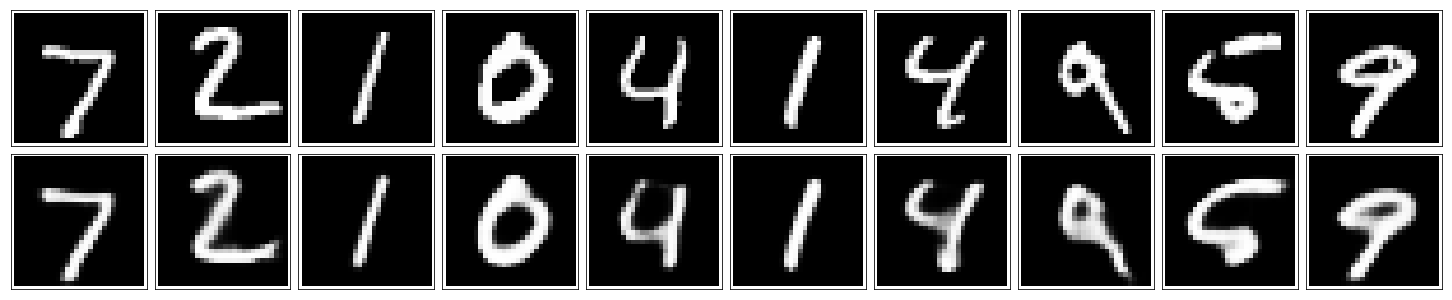

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [19]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [21]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [22]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

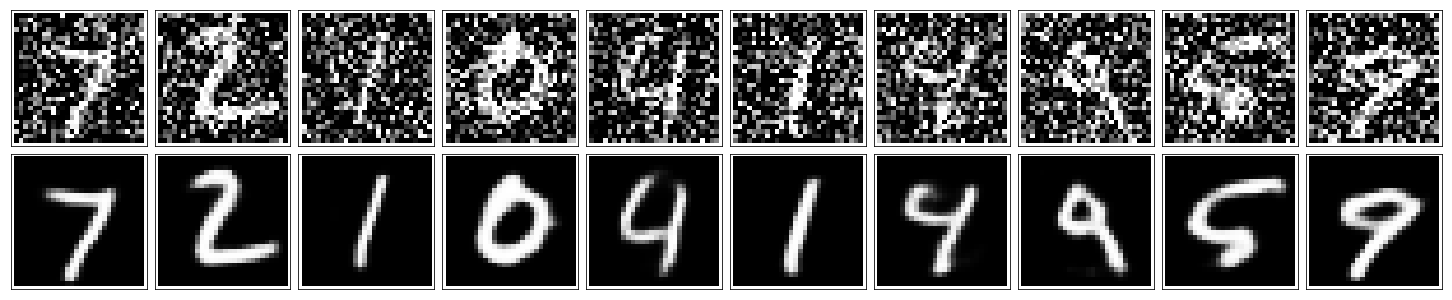

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)